In [1]:
import datetime
print(f'Updated: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')

Updated: 2025-03-15 08:05:13


In [2]:
import xarray as xr
from netCDF4 import Dataset
import os
import glob
import dask.distributed as dd
import dask
import dask.array as da
import time
import sys
import calendar
from datetime import datetime, timedelta
import numpy as np
import wrf
from itertools import product

import wrf
from wrf import interplevel

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
%matplotlib inline

plt.rcParams['text.usetex'] = False

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.dates import HourLocator, DateFormatter, MinuteLocator

import cartopy
from cartopy import crs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

from cmcrameri import cm

from windrose import WindroseAxes

from scipy.stats import weibull_min

import seaborn as sns
import seaborn.objects as so

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator

from scipy.stats import linregress


from meteostat import Stations
from datetime import datetime
from meteostat import Hourly

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as R2

import wrf
from wrf import (getvar, interplevel, vertcross,
                 CoordPair, ALL_TIMES, to_np,
                 get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim,
                 interpline, ll_to_xy,extract_global_attrs)

root_dir = '/media/ssd_4tb_qvo/Modeling-Frontal-Low-Level-Jets-and-Associated-Extreme-Wind-Ramps'

from data_processing.libraries import *

In [3]:
fig_dir = '/home/harish/Dropbox/Apps/Overleaf/Modelling Frontal Low-level Jets and Associated Extreme Wind Ramps'
conference_fig_dir = '/home/harish/OneDrive_me16d412/Presentations/AMS2025/14th_Jan_FLLJ'
buoy_locations = {'LOT1': [51.706898,3.034618], 'LOT2': [51.6463,2.95141], 'Herstomonceux': [50.9, 0.32]}

contour_levels = [[np.arange(0, 30.1, 1),np.arange(0,30.1,1),np.arange(-15, 16, 1)],
                  [np.arange(0, 30.1, 1),np.arange(0,30.1,1),np.arange(-10, 11, 1)]]
angles = [165,450]
subplot_letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

# Spatial plot of WRF model domains

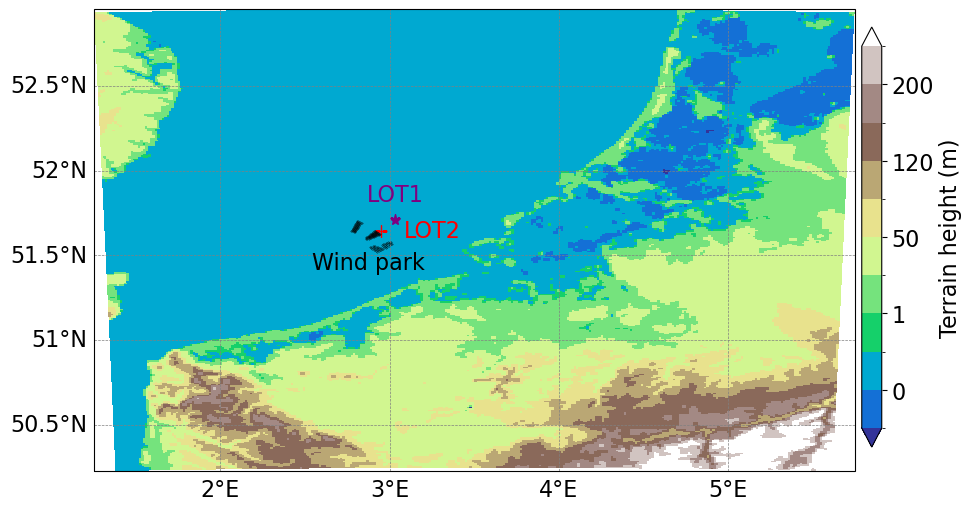

In [5]:
ds = xr.open_dataset(f'{root_dir}/WES_dataset/WRF_simulations/FLLJ_1/CERRA-1d1kmMYFP/geo_em.d01.nc')
plot_data = ds.HGT_M[0, ...].assign_coords(latitude=ds.XLAT_M[0,...],longitude=ds.XLONG_M[0,...])

# Define the custom color levels and colormap
clevels = [-5, 0, 0.5, 1, 10, 50, 80, 120, 160, 200, 240]
cmap = plt.get_cmap("terrain")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 1, figsize=(10, 6),width_ratios=[1], subplot_kw={'projection':ccrs.PlateCarree()})

# Plot the data for the first file in the first subplot
im1 = plot_data.plot(x='longitude',y='latitude',levels=clevels, cmap=cmap, ax=axes,add_colorbar=False)
#cbar = plt.colorbar(im1, ax=axes[0], shrink=0.5)
#cbar.set_label('Terrain height (m)')
gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle='--', linewidth=0.5, color='gray')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

# Illustrate the observational points
label = 'LOT1'
lat, lon = buoy_locations[label]
axes.text(lon, lat + 0.15, label, color='purple', fontsize=16, ha='center', va='center')
marker = '*'
axes.plot(lon, lat, marker, markersize=8,color='purple')

label = 'LOT2'
lat, lon = buoy_locations[label]
axes.text(lon+0.3, lat, label, color='red', fontsize=16, ha='center', va='center')
marker = '+'
axes.plot(lon, lat, marker, markersize=8,color='red')

ds = xr.open_dataset(f'{root_dir}/borssele_wind_turbines.nc')
for i in range(len(ds.lon)):
    axes.plot(ds.lon[i], ds.lat[i], '.', markersize=0.5,color='black')
axes.text(ds.lon[50], ds.lat[50]-0.15, 'Wind park', color='black', fontsize=16, ha='center', va='center')

# Add colorbar spanning both subplots
cax = plt.axes([0.9, 0.15, 0.02, 0.7])  # Adjust the position and size of the colorbar
cbar = plt.colorbar(im1, cax=cax)
cbar.set_label('Terrain height (m)', fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.savefig(f'{fig_dir}/Domain_terrain_height.png',dpi=300,bbox_inches='tight')

# Wind power time-series

## Grid power and synoptic charts of each case

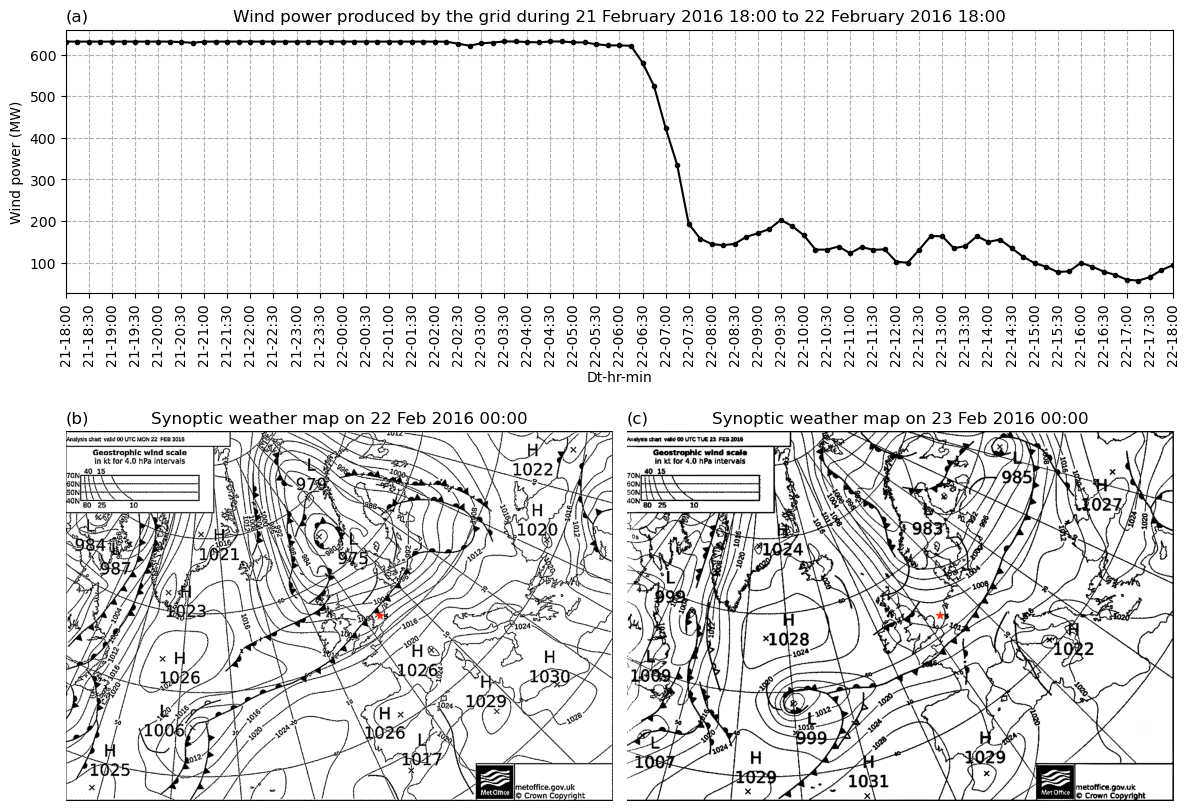

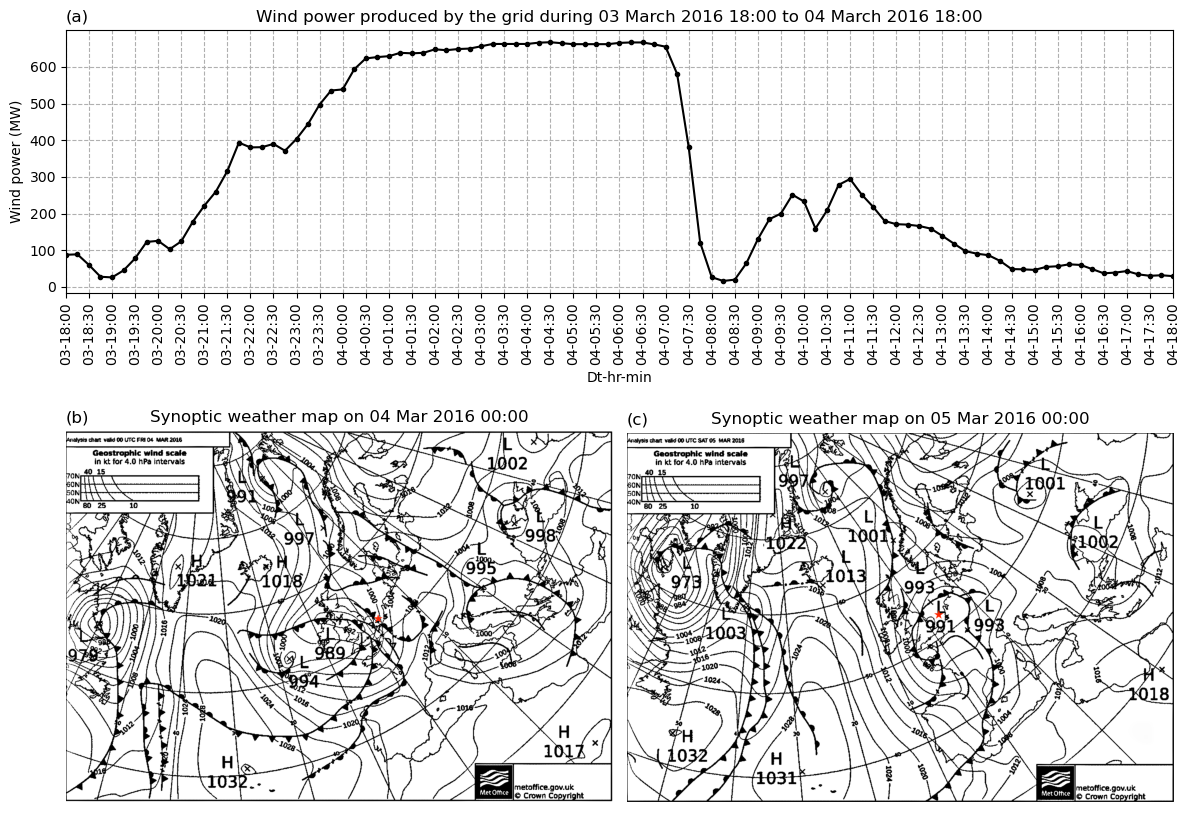

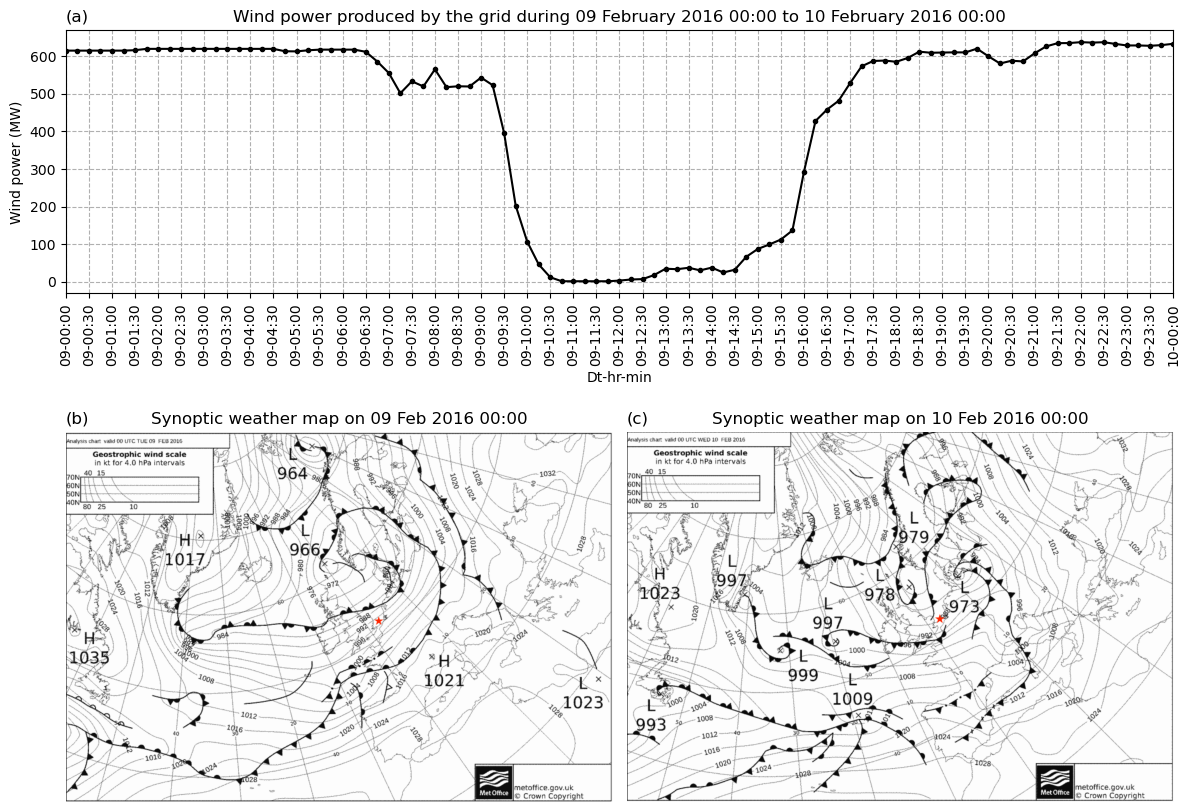

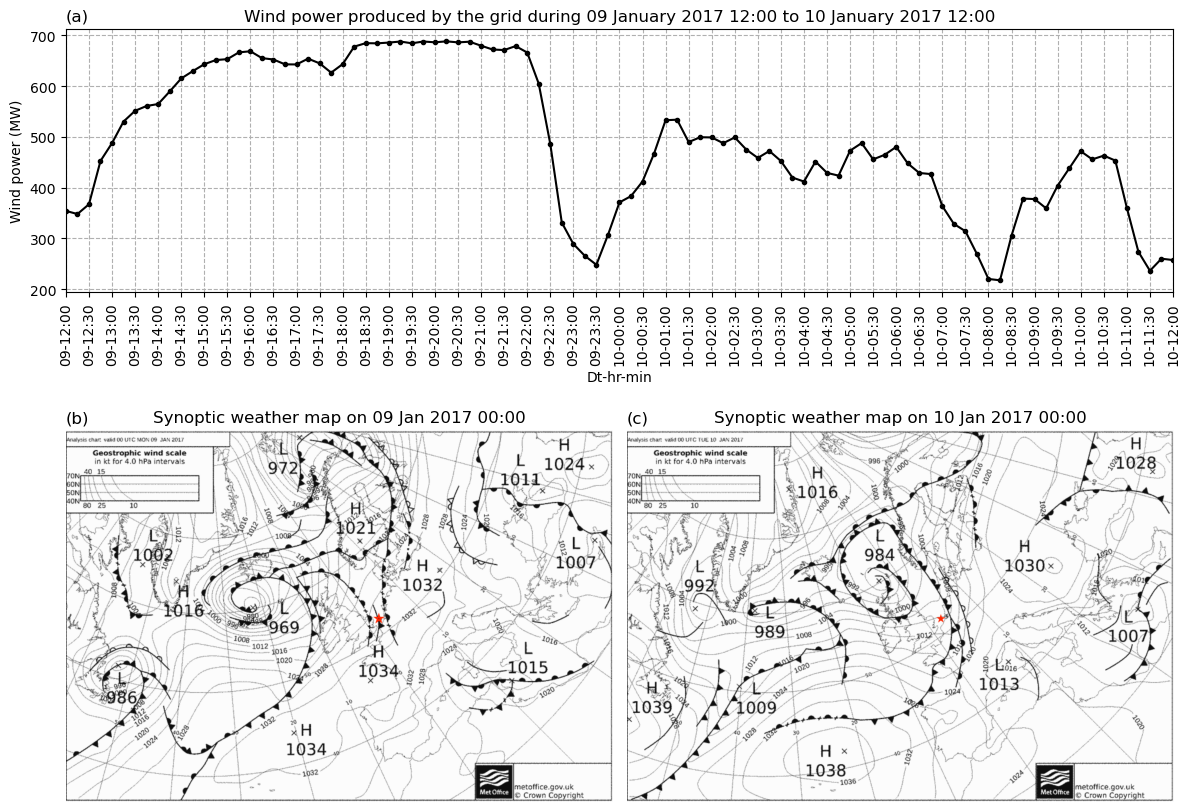

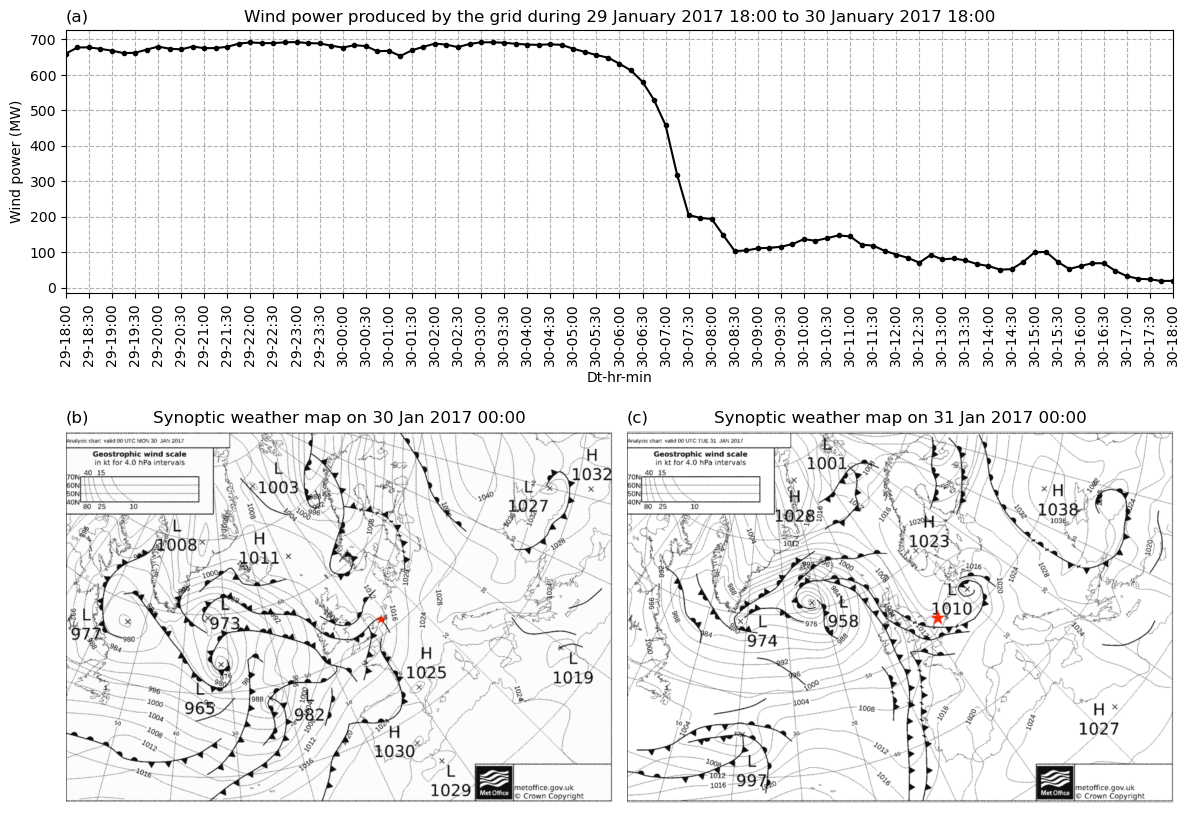

In [6]:
grid_power_file = f"{root_dir}/WES_dataset/Elia_dataset/Elia_wind_power.csv"
grid_power = pd.read_csv(grid_power_file, index_col=0)
grid_power = grid_power.rename_axis('times')
grid_power.index = pd.to_datetime(grid_power.index)
# Rename the first column to 'obs_power'
grid_power = grid_power.rename(columns={'Measured & upscaled [MW]': 'obs_power'})

# Mapping subplot titles
synoptic_titles = [['22 Feb 2016 00:00','23 Feb 2016 00:00'],
                   ['04 Mar 2016 00:00','05 Mar 2016 00:00'],
                   ['09 Feb 2016 00:00','10 Feb 2016 00:00'],
                   ['09 Jan 2017 00:00','10 Jan 2017 00:00'],
                    ['30 Jan 2017 00:00','31 Jan 2017 00:00']
                    ]

for case in [1, 2, 3, 4, 5]:
    #fig, ax = plt.subplots(1, 1, figsize=(12, 9), layout='constrained')
    # Create 2x2 grid layout
    fig = plt.figure(figsize=(12, 9))
    gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 2])

    # Plot time series in gs[0, :]
    ax = fig.add_subplot(gs[0, :])
    # Data selection for the current event period
    data = grid_power.loc[event_periods[case - 1][0]:event_periods[case - 1][1], ['obs_power']]
    index = data.index

    # Plotting
    ax.plot(index, data, '.-', color='k')
    start_date = pd.to_datetime(event_periods[case - 1][0]).strftime('%d %B %Y %H:%M')
    end_date = pd.to_datetime(event_periods[case - 1][1]).strftime('%d %B %Y %H:%M')
    ax.set_title(f"({subplot_letters[0]})",loc='left')
    ax.set_title(f"Wind power produced by the grid during {start_date} to {end_date}",
                 loc='center')
    ax.set_ylabel('Wind power (MW)')
    ax.set_xlabel('Dt-hr-min')
    
    # Setting x-axis tick labels in day-hr-min format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H:%M'))
    ax.set_xticks(index[::2])
    ax.set_xticklabels([dt.strftime('%d-%H:%M') for dt in index[::2]], rotation='vertical')
    ax.set_xlim(index[0], index[-1])
    ax.grid(linestyle='dashed')

    # Read and plot PNG images
    image1_path = f"{root_dir}/WES_dataset/WRF_simulations/FLLJ_{case}/synoptic_surface_chart_1.png"  # Update with actual path
    image2_path = f"{root_dir}/WES_dataset/WRF_simulations/FLLJ_{case}/synoptic_surface_chart_2.png"  # Update with actual path

    # Plot first image in gs[1, 0]
    ax2 = fig.add_subplot(gs[1, 0])
    img1 = mpimg.imread(image1_path)
    ax2.imshow(img1)
    ax2.axis('off')  # Hide axes for the image
    ax2.set_title(f"({subplot_letters[1]})",loc='left')
    ax2.set_title(f"Synoptic weather map on {synoptic_titles[case - 1][0]}",loc='center')

    # Plot second image in gs[1, 1]
    ax3 = fig.add_subplot(gs[1, 1])
    img2 = mpimg.imread(image2_path)
    ax3.imshow(img2)
    ax3.axis('off')  # Hide axes for the image
    ax3.set_title(f"({subplot_letters[2]})",loc='left')
    ax3.set_title(f"Synoptic weather map on {synoptic_titles[case - 1][1]}",loc='center')

    # Adjust layout and save the figure
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'{fig_dir}/Grid_power_timeseries_FLLJ_{case}.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)

## Grid power compared with WRF simulated, CERRA, and ERA5 wind power

In [8]:
def plot_lines_timeseries(ax,index,data,color,marker,line,label,title,xlabel=None,ylabel=None,xticks=None,yticks=None,tick_interval=3):
    ax.plot(index,data,f'{marker}{line}',color=color,label=label,markersize=4)
    ax.set_title(title,fontsize=16)
    ax.set_ylabel(ylabel,fontsize=16) if ylabel else None
    ax.set_xlabel(xlabel,fontsize=16) if xlabel else None
    # set y-axis tick labels font size
    ax.tick_params(axis='y', labelsize=12)

    # get x-axis ticks at every 30 minutes
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%da-%H-%M'))
    minute_locator = MinuteLocator(interval=30)
    ax.xaxis.set_minor_locator(minute_locator)
    ax.set_xticks(index[::tick_interval])
    
    if xticks:
        # Set x-axis tick labels in day-hr-min format
        ax.set_xticklabels([dt.strftime('%d-%H:%M') for dt in index[::tick_interval]], rotation='vertical', fontsize=12)
    else:
        # dont set x ticks labels
        ax.set_xticklabels([])
    
    ax.set_xlim(index[0],index[-1])

    # set y-axis ticks
    if yticks is not None:
        ax.set_yticks(yticks)
    else:
        ax.set_yticks([])

    ax.grid(linestyle='dashed')
    return ax 

In [65]:
wind_power_time_series = {}
for case in [1,2,3,4,5]:
    case_dir = f'FLLJ_{case}'
    wind_power_time_series[case_dir] = {}
    '''
    The observed wind power at the grid are indeed stored at UTC.
    '''
    grid_power_file = f"{root_dir}/WES_dataset/Elia_dataset/Elia_wind_power.csv"
    grid_power = pd.read_csv(grid_power_file, index_col=0)
    grid_power = grid_power.rename_axis('times')
    grid_power.index = pd.to_datetime(grid_power.index)
    # Rename the first column to 'obs_power'
    grid_power = grid_power.rename(columns={'Measured & upscaled [MW]': 'obs_power'})
    grid_power = grid_power.rename(columns={'Day-ahead forecast (11h00) [MW]': 'forecast_power'})
    grid_power = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1],['obs_power','forecast_power']]
    
    for i,run in enumerate([1,2,3,4,5,8,16,17]):
        run_name = run_names[run-1]
        try :
            files = glob.glob(f'{root_dir}/WES_dataset/WRF_simulations/{case_dir}/{run_name}/turbine_power.nc')
            ds = xr.open_dataset(files[0])
            ds = ds.sel(Time=slice(ramp_periods[case-1][0],ramp_periods[case-1][1]))
            # Check if 'power' exists in the dataset's variable names, otherwise check for 'POWER'
            var_name = 'power' if 'power' in ds else 'POWER'
            if case == 1 and run == 8:
                grid_power[run_name] = ds[var_name].values/1e6
            elif run == 3 or run == 4 or run == 6 or run == 7 or run == 15:
                grid_power[run_name] = ds[var_name].values[::3]/1e3 
            else:
                grid_power[run_name] = ds[var_name].values[::3]/1e6
        except:
            print(f"File not found for {case_dir} {run_name}")
            continue
    
    # adding CERRA and ERA5 wind power
    # ERA5
    files = glob.glob(f'{root_dir}/WES_dataset/ERA5/{case_dir}/turbine_power.nc')
    ds = xr.open_dataset(files[0])
    var_name = 'power' if 'power' in ds else 'POWER'
    grid_power['ERA5'] = ds[var_name].resample(time='15T').mean().values/1e3

    # CERRA
    files = glob.glob(f'{root_dir}/WES_dataset/CERRA/{case_dir}/turbine_power.nc')
    ds = xr.open_dataset(files[0])
    var_name = 'power' if 'power' in ds else 'POWER'
    grid_power['CERRA'] = ds[var_name].resample(time='15T').mean().values/1e3
    
    wind_power_time_series[case_dir] = grid_power

File not found for FLLJ_3 ERA5-3d1kmMYFP
File not found for FLLJ_3 GFS-3d1kmMYFP
File not found for FLLJ_3 CERRA-1d1kmMYFP_100_levels
File not found for FLLJ_3 CERRA-1d1kmMYFP_12hr_spinup
File not found for FLLJ_4 ERA5-3d1kmMYFP
File not found for FLLJ_4 GFS-3d1kmMYFP
File not found for FLLJ_4 CERRA-1d1kmMYFP_100_levels
File not found for FLLJ_4 CERRA-1d1kmMYFP_12hr_spinup
File not found for FLLJ_5 ERA5-3d1kmMYFP
File not found for FLLJ_5 GFS-3d1kmMYFP
File not found for FLLJ_5 CERRA-1d1kmMYFP_100_levels
File not found for FLLJ_5 CERRA-1d1kmMYFP_12hr_spinup


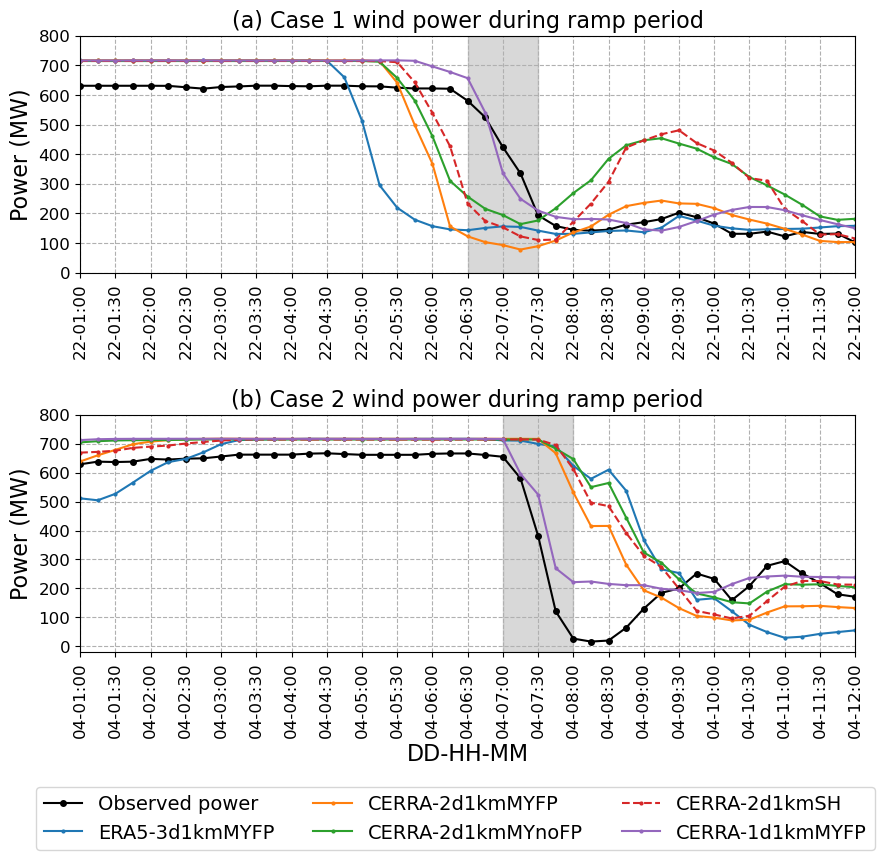

In [60]:
# create 10 custom colors, custom markers
ramp_durations = [['2016-02-22T06:30', '2016-02-22T07:30'],['2016-03-04T07:00', '2016-03-04T08:00']]
colors = sns.color_palette("tab10", 10)
colors = [(0, 0, 0)] + colors
markers = ['o','s','^','v','<','>','1','2','3','4','5']
linestyles = ['-','-','-','--','-','--','--','--']
fig = plt.figure(figsize=(10, 8))
gs = plt.GridSpec(2,1,hspace=0.6)
for i,case in enumerate([1,2]):
    case_dir = f'FLLJ_{case}'
    ax = fig.add_subplot(gs[i])
    xticks=True
    xlabel='DD-HH-MM' if i == 1 else None
    title = f'({subplot_letters[i]}) Case {case} wind power during ramp period'
    grid_power = wind_power_time_series[case_dir]
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    plot_lines_timeseries(ax,data.index,data['obs_power'],colors[0],markers[0],'-','Observed power',f'FLLJ {case}',yticks=np.arange(0, 801, 100),tick_interval=2)
    for j,run in enumerate([1,2,3,4,5]):
        run_name = run_names[run-1]
        plot_lines_timeseries(ax,data.index,data[run_name],colors[j+1],'.',linestyles[j],run_name,title,
                              xlabel=xlabel,ylabel='Power (MW)',xticks=xticks,yticks=np.arange(0, 801, 100),tick_interval=2)
    
    # Add vertical shading for the specific ramp durations
    start_time = pd.to_datetime(ramp_durations[case - 1][0])
    end_time = pd.to_datetime(ramp_durations[case - 1][1])
    ax.axvspan(start_time, end_time, color='grey', alpha=0.3)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center',ncol=3,bbox_to_anchor=(0.5,-0.15),fontsize=14)
plt.savefig(f'{fig_dir}/FLLJ_1-2_wind_power_timeseries(3hCERRA).pdf', dpi=300, bbox_inches='tight')

                     obs_power  forecast_power  ERA5-3d1kmMYFP  \
times                                                            
2016-02-22 01:00:00     631.03          659.11      716.417297   
2016-02-22 01:15:00     631.03          659.29      716.471069   
2016-02-22 01:30:00     631.03          659.46      716.520752   
2016-02-22 01:45:00     631.03          659.64      716.541077   
2016-02-22 02:00:00     631.03          659.62      716.662537   

                     CERRA-2d1kmMYFP  CERRA-2d1kmMYnoFP  CERRA-2d1kmSH  \
times                                                                    
2016-02-22 01:00:00       716.299255         714.530273     714.706954   
2016-02-22 01:15:00       716.366577         714.529717     714.713490   
2016-02-22 01:30:00       716.412903         714.530479     714.713901   
2016-02-22 01:45:00       716.438354         714.530917     714.712157   
2016-02-22 02:00:00       716.441589         714.530852     714.712099   

                  

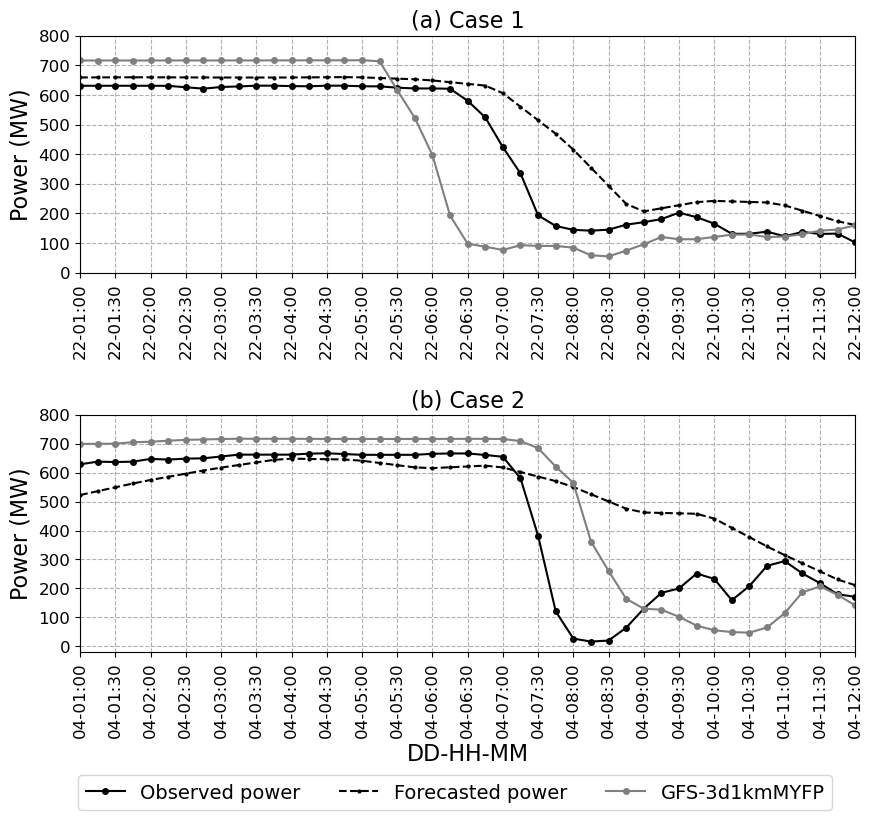

In [127]:
# create 10 custom colors, custom markers
colors = sns.color_palette("tab10", 10)
colors = [(0, 0, 0)] + colors
markers = ['o','s','^','v','<','>','1','2','3','4','5']
fig = plt.figure(figsize=(10, 8))
gs = plt.GridSpec(2,1,hspace=0.6)
for i,case in enumerate([1,2]):
    case_dir = f'FLLJ_{case}'
    run = 8
    ax = fig.add_subplot(gs[i])
    grid_power = wind_power_time_series[case_dir]
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    print(data.head())
    xticks = True
    xlabel = 'DD-HH-MM' if i == 1 else None
    title = f'({subplot_letters[i]}) Case {case}'
    plot_lines_timeseries(ax,data.index,data['obs_power'],colors[0],markers[0],'-','Observed power',f'FLLJ {case}',yticks=np.arange(0, 801, 100),tick_interval=2)
    plot_lines_timeseries(ax,data.index,data['forecast_power'],colors[0],'.','--','Forecasted power',f'FLLJ {case}',yticks=np.arange(0, 801, 100),tick_interval=2)
    plot_lines_timeseries(ax,data.index,data[run_names[run-1]],colors[run],markers[0],'-',run_names[run-1],title,
                              xlabel=xlabel,ylabel='Power (MW)',xticks=xticks,yticks=np.arange(0, 801, 100),tick_interval=2)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center',ncol=4,bbox_to_anchor=(0.5,-0.1),fontsize=14)

plt.savefig(f'{fig_dir}/{run_names[run-1]}_wind_power_timeseries.pdf', dpi=300, bbox_inches='tight')

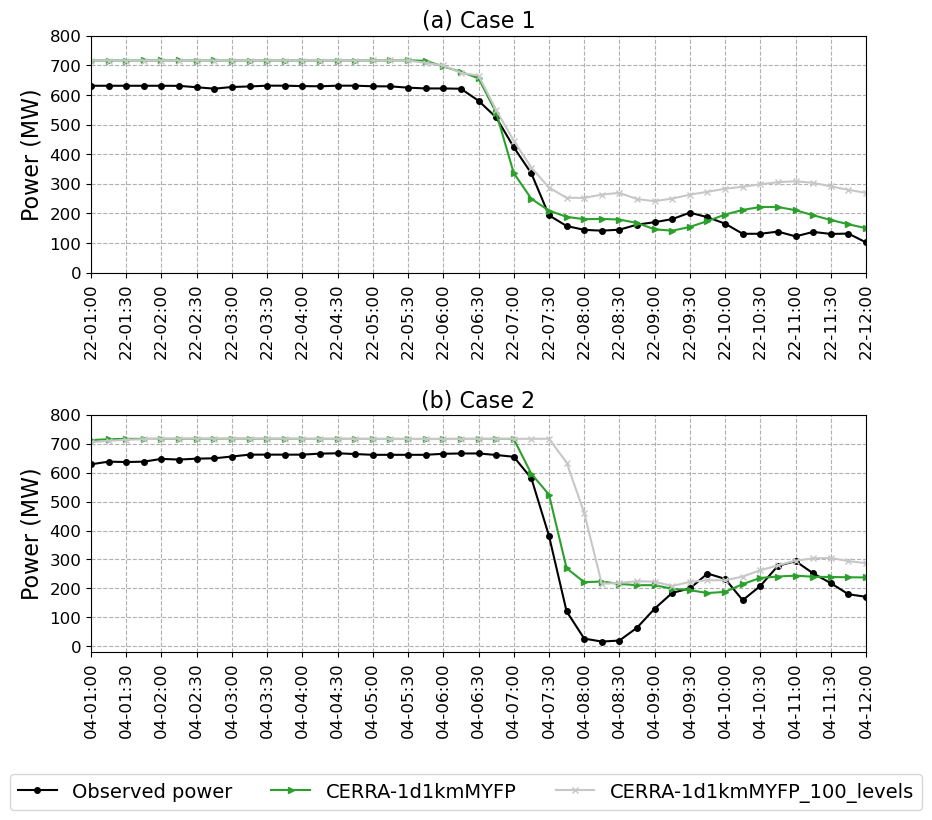

In [129]:
# create 10 custom colors, custom markers
colors = sns.color_palette("tab20", 20)
colors = [(0, 0, 0)] + colors
markers = ['o','s','^','v','<','>','1','2','3','4','8','s','p','*','h','+','x','D','d','|']
fig = plt.figure(figsize=(10, 8))
gs = plt.GridSpec(2,1,hspace=0.6)
for i,case in enumerate([1,2]):
    case_dir = f'FLLJ_{case}'
    ax = fig.add_subplot(gs[i,0])
    xticks=True
    xlabel = 'DD-HH-MM' if i == 2 else None
    title = f'({subplot_letters[i]}) Case {case}'
    grid_power = wind_power_time_series[case_dir]
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    plot_lines_timeseries(ax,data.index,data['obs_power'],colors[0],markers[0],'-','Observed power',f'FLLJ {case}',yticks=np.arange(0, 801, 100),tick_interval=2)
    run = 5
    plot_lines_timeseries(ax,data.index,data[run_names[run-1]],colors[run],markers[run],'-',run_names[run-1],title,
                            xlabel=xlabel,ylabel='Power (MW)',xticks=xticks,yticks=np.arange(0, 801, 100),tick_interval=2)
    run = 16
    plot_lines_timeseries(ax,data.index,data[run_names[run-1]],colors[run],markers[run],'-',f'{run_names[5-1]}_100_levels',title,
                            xlabel=xlabel,ylabel='Power (MW)',xticks=xticks,yticks=np.arange(0, 801, 100),tick_interval=2)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center',ncol=4,bbox_to_anchor=(0.5,-0.1),fontsize=14)
plt.savefig(f'{fig_dir}/FLLJ_1-2_wind_power_timeseries(3hCERRA)_vertical_levels_sensitivity.pdf', dpi=300, bbox_inches='tight')

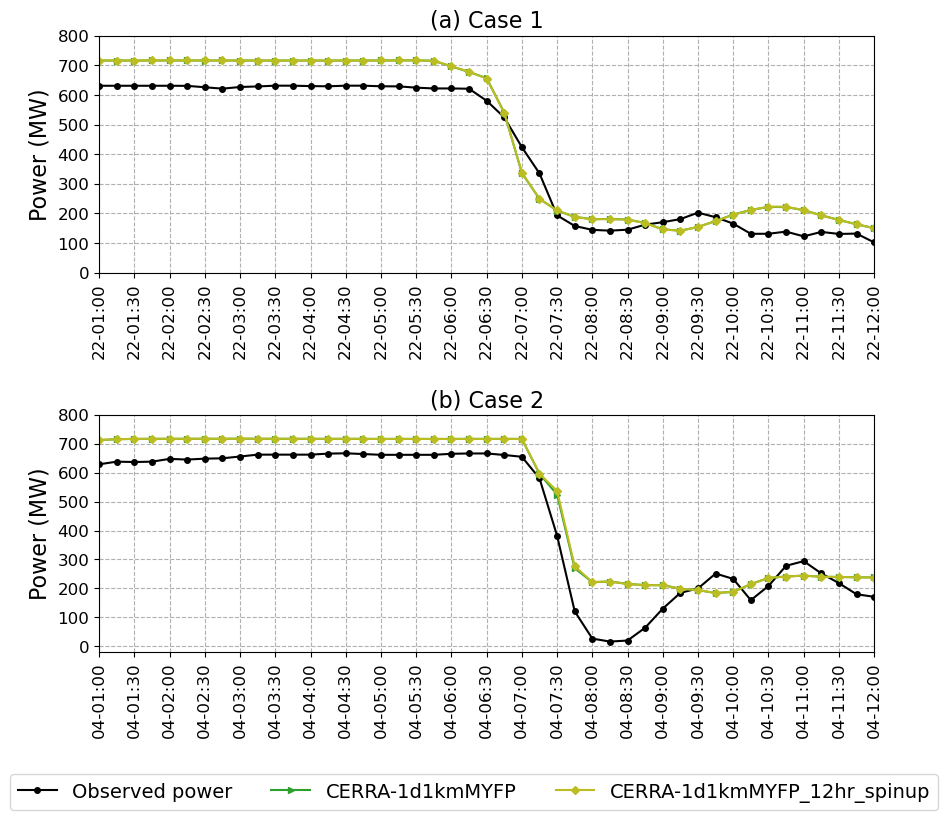

In [130]:
# create 10 custom colors, custom markers
colors = sns.color_palette("tab20", 20)
colors = [(0, 0, 0)] + colors
markers = ['o','s','^','v','<','>','1','2','3','4','8','s','p','*','h','+','x','D','d','|']
fig = plt.figure(figsize=(10, 8))
gs = plt.GridSpec(2,1,hspace=0.6)
for i,case in enumerate([1,2]):
    case_dir = f'FLLJ_{case}'
    ax = fig.add_subplot(gs[i,0])
    xticks=True
    xlabel = 'DD-HH-MM' if i == 2 else None
    title = f'({subplot_letters[i]}) Case {case}'
    grid_power = wind_power_time_series[case_dir]
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    plot_lines_timeseries(ax,data.index,data['obs_power'],colors[0],markers[0],'-','Observed power',f'FLLJ {case}',yticks=np.arange(0, 801, 100),tick_interval=2)
    run = 5
    plot_lines_timeseries(ax,data.index,data[run_names[run-1]],colors[run],markers[run],'-',run_names[run-1],title,
                            xlabel=xlabel,ylabel='Power (MW)',xticks=xticks,yticks=np.arange(0, 801, 100),tick_interval=2)
    run = 17
    plot_lines_timeseries(ax,data.index,data[run_names[run-1]],colors[run],markers[run],'-',f'{run_names[5-1]}_12hr_spinup',title,
                            xlabel=xlabel,ylabel='Power (MW)',xticks=xticks,yticks=np.arange(0, 801, 100),tick_interval=2)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center',ncol=4,bbox_to_anchor=(0.5,-0.1),fontsize=14)
plt.savefig(f'{fig_dir}/FLLJ_1-2_wind_power_timeseries(3hCERRA)_spinup_sensitivity.pdf', dpi=300, bbox_inches='tight')

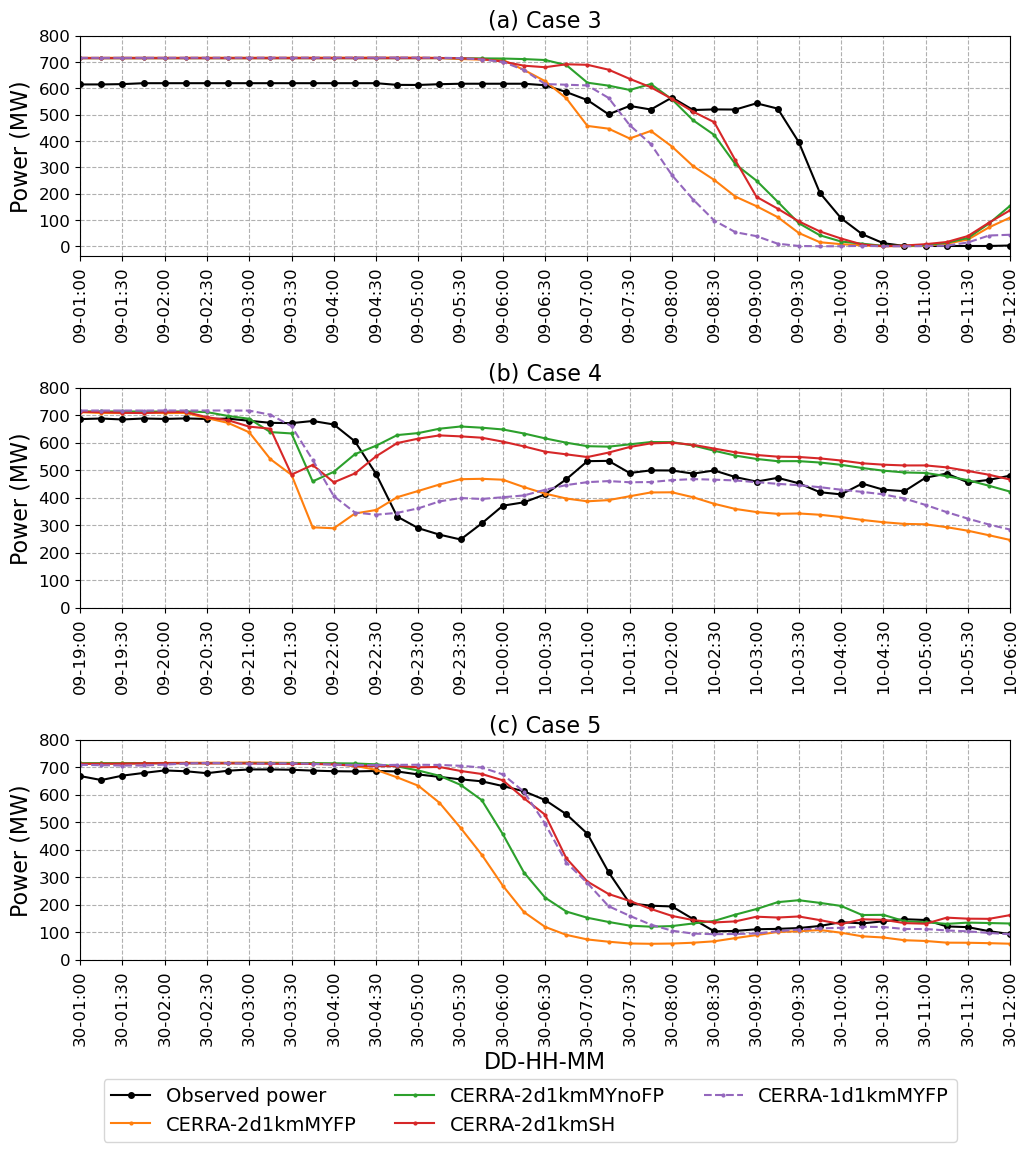

In [128]:
# create 10 custom colors, custom markers
ramp_durations = [['2016-02-22T06:30', '2016-02-22T07:30'],['2016-03-04T07:00', '2016-03-04T08:00'],['2016-02-09-T09:00','2016-02-09-T10:00']]
colors = sns.color_palette("tab10", 10)
colors = [(0, 0, 0)] + colors
markers = ['o','s','^','v','<','>','1','2','3','4','5']
linestyles = ['-','-','-','--','-','--','--','--']
fig = plt.figure(figsize=(12, 12))
gs = plt.GridSpec(3,1,hspace=0.6)
for i,case in enumerate([3,4,5]):
    case_dir  = f'FLLJ_{case}'
    ax = fig.add_subplot(gs[i])
    xticks=True
    xlabel='DD-HH-MM' if i == 2 else None
    title = f'({subplot_letters[i]}) Case {case}'
    grid_power = wind_power_time_series[case_dir]
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    plot_lines_timeseries(ax,data.index,data['obs_power'],colors[0],markers[0],'-','Observed power',f'FLLJ {case}',yticks=np.arange(0, 801, 100),tick_interval=2)
    for j,run in enumerate([2,3,4,5]):
        run_name = run_names[run-1]
        plot_lines_timeseries(ax,data.index,data[run_name],colors[j+2],'.',linestyles[j],run_name,title,
                              xlabel=xlabel,ylabel='Power (MW)',xticks=xticks,yticks=np.arange(0, 801, 100),tick_interval=2)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center',ncol=3,bbox_to_anchor=(0.5,-0.05),fontsize=14)
plt.savefig(f'{fig_dir}/FLLJ_3-5_wind_power_timeseries(3hCERRA).pdf', dpi=300, bbox_inches='tight')

### Power ramp statistics

In [ ]:
ramp_instances = {}
ramp_statistics = {}
for case in [1,2,3,4,5]:
    case_dir = f'FLLJ_{case}'
    ramp_instances[case] = {}
    ramp_statistics[case] = {}
    my_list = []
    grid_power = wind_power_time_series[case_dir]
    data = grid_power.loc[ramp_periods[case-1][0]:ramp_periods[case-1][1]]
    times = pd.DataFrame(data.index)
    rated_power = 712.2
    obs_power = data[f'obs_power']
    cf_grid = obs_power/rated_power
    multiindex_tuples = []
    for j in [1,2,4]: #Loops through 15 min, 30min, and 1hr
        dmy = []
        # === Grid power ===
        del_cf_grid = np.array([(cf_grid.iloc[i+j]-cf_grid.iloc[i])*100 for i in range(len(cf_grid)-j)])
        dmy.append(round(np.min(del_cf_grid),1)*-1)
        dmy.append(times['times'].iloc[np.argmin(del_cf_grid)].strftime('%H:%M'))
        if j == 4:
            multiindex_tuples.append(('Grid_power', 'Delta_CF'))
            multiindex_tuples.append(('Grid_power', 'Time_instance'))

        # === Grid forecast ===
        if case == 1 or case == 2:
            label = 'forecast_power'
            forecast_power = data[f'{label}']
            cf_forecast = forecast_power/rated_power
            del_cf_forecast = np.array([(cf_forecast.iloc[i+j]-cf_forecast.iloc[i])*100 for i in range(len(cf_forecast)-j)])
            dmy.append(round(np.min(del_cf_forecast),1)*-1)
            dmy.append(times['times'].iloc[np.argmin(del_cf_forecast)].strftime('%H:%M'))
            if j == 4:
                multiindex_tuples.append(('Forecast_power', 'Delta_CF'))
                multiindex_tuples.append(('Forecast_power', 'Time_instance'))

        # === WRF ===
        for run in [1,2,3,4,5,8]:
            label = run_names[run-1]
            try:
                wrf_power = data[f'{label}']
                cf_wrf = wrf_power/rated_power
                del_cf_wrf = np.array([(cf_wrf.iloc[i+j]-cf_wrf.iloc[i])*100 for i in range(len(cf_wrf)-j)])
                dmy.append(round(np.min(del_cf_wrf),1)*-1)
                dmy.append(times['times'].iloc[np.argmin(del_cf_wrf)].strftime('%H:%M'))
                if j == 4:
                    ramp_instances[case][run] = times['times'].iloc[np.argmin(del_cf_wrf)].strftime('%Y-%m-%dT%H:%M')
                if j == 4:
                    multiindex_tuples.append((label, 'Delta_CF'))
                    multiindex_tuples.append((label, 'Time_instance'))
            except:
                continue
        # === CERRA ===
        label = 'CERRA'
        cerra_power = data[f'{label}']
        cf_cerra = cerra_power/rated_power
        del_cf_cerra = np.array([(cf_cerra.iloc[i+j]-cf_cerra.iloc[i])*100 for i in range(len(cf_cerra)-j)])
        if j==4:
            dmy.append(round(np.nanmin(del_cf_cerra),1)*-1)
            dmy.append(times['times'].iloc[np.nanargmin(del_cf_cerra)].strftime('%H:%M'))
            multiindex_tuples.append(('CERRA', 'Delta_CF'))
            multiindex_tuples.append(('CERRA', 'Time_instance'))
        else:
            dmy.append('')
            dmy.append('')

        # === ERA5 ===
        label = 'ERA5'
        era5_power = data[f'{label}']
        cf_era5 = era5_power/rated_power
        del_cf_era5 = np.array([(cf_era5.iloc[i+j]-cf_era5.iloc[i])*100 for i in range(len(cf_era5)-j)])
        if j==4:
            dmy.append(round(np.nanmin(del_cf_era5),1)*-1)
            dmy.append(times['times'].iloc[np.nanargmin(del_cf_era5)].strftime('%H:%M'))
            multiindex_tuples.append(('ERA5', 'Delta_CF'))
            multiindex_tuples.append(('ERA5', 'Time_instance'))
        else:
            dmy.append('')
            dmy.append('')
        
        my_list.append(dmy)

    columns = pd.MultiIndex.from_tuples(multiindex_tuples)
    index = ['15min','30min','1hr']
    df = pd.DataFrame(my_list,columns=columns,index=index)
    ramp_statistics[case] = df

In [118]:
ramp_statistics[1]

Grid_power               Forecast_power               ERA5-3d1kmMYFP  \
        Delta_CF Time_instance       Delta_CF Time_instance       Delta_CF   
15min       19.9         07:15            8.6         08:00           30.6   
30min       32.3         07:00           17.2         08:00           51.2   
1hr         54.3         06:30           33.2         07:45           69.8   

                    CERRA-2d1kmMYFP               CERRA-2d1kmMYnoFP  \
      Time_instance        Delta_CF Time_instance          Delta_CF   
15min         05:00            29.7         06:00              21.1   
30min         04:45            48.0         05:45              38.0   
1hr           04:30            78.4         05:15              56.4   

                    CERRA-2d1kmSH               CERRA-1d1kmMYFP                \
      Time_instance      Delta_CF Time_instance        Delta_CF Time_instance   
15min         06:00          27.2         06:15            28.7         06:45   
30min         05:45          43.0         06:00            45.0         06:30   
1hr           05:15          67.0         05:30            62.8         06:30   

      GFS-3d1kmMYFP                  CERRA                   ERA5  \
           Delta_CF Time_instance Delta_CF Time_instance Delta_CF   
15min          28.6         06:00                                   
30min          46.3         05:45                                   
1hr            73.1         05:15     41.9         06:00     22.4   

                     
      Time_instance  
15min                
30min                
1hr           07:00

In [119]:
ramp_statistics[2]

Grid_power               Forecast_power               ERA5-3d1kmMYFP  \
        Delta_CF Time_instance       Delta_CF Time_instance       Delta_CF   
15min       36.7         07:30            4.5         10:30           23.9   
30min       64.6         07:15            9.0         10:15           38.1   
1hr         88.2         07:00           17.7         10:00           52.9   

                    CERRA-2d1kmMYFP               CERRA-2d1kmMYnoFP  \
      Time_instance        Delta_CF Time_instance          Delta_CF   
15min         08:45            19.0         07:45              16.9   
30min         08:45            35.3         07:45              33.7   
1hr           08:45            54.1         07:45              46.8   

                    CERRA-2d1kmSH               CERRA-1d1kmMYFP                \
      Time_instance      Delta_CF Time_instance        Delta_CF Time_instance   
15min         08:45          16.3         08:00            35.8         07:30   
30min         08:30          27.9         07:45            45.8         07:15   
1hr           08:30          42.7         07:45            69.5         07:00   

      GFS-3d1kmMYFP                  CERRA                   ERA5  \
           Delta_CF Time_instance Delta_CF Time_instance Delta_CF   
15min          28.5         08:00                                   
30min          42.7         08:00                                   
1hr            64.2         07:45     46.0         08:00     43.9   

                     
      Time_instance  
15min                
30min                
1hr           07:00

In [122]:
ramp_statistics[3]

Grid_power               CERRA-2d1kmMYFP                \
        Delta_CF Time_instance        Delta_CF Time_instance   
15min       27.1         09:30            14.8         06:45   
30min       45.0         09:15            23.9         06:30   
1hr         67.0         09:15            35.2         06:00   

      CERRA-2d1kmMYnoFP               CERRA-2d1kmSH                \
               Delta_CF Time_instance      Delta_CF Time_instance   
15min              15.6         08:30          20.3         08:30   
30min              24.4         08:30          39.8         08:30   
1hr                47.1         08:30          52.9         08:30   

      CERRA-1d1kmMYFP                  CERRA                   ERA5  \
             Delta_CF Time_instance Delta_CF Time_instance Delta_CF   
15min            16.6         07:45                                   
30min            29.6         07:45                                   
1hr              54.2         07:15     39.2         07:00     31.3   

                     
      Time_instance  
15min                
30min                
1hr           08:00

In [123]:
ramp_statistics[4]

Grid_power               CERRA-2d1kmMYFP                \
        Delta_CF Time_instance        Delta_CF Time_instance   
15min       21.8         22:30            26.8         21:30   
30min       38.4         22:15            34.8         21:15   
1hr         52.9         22:00            53.3         20:45   

      CERRA-2d1kmMYnoFP               CERRA-2d1kmSH                \
               Delta_CF Time_instance      Delta_CF Time_instance   
15min              24.5         21:30          23.4         21:15   
30min              25.2         21:15          24.5         21:00   
1hr                33.4         20:45          29.3         20:30   

      CERRA-1d1kmMYFP                  CERRA                   ERA5  \
             Delta_CF Time_instance Delta_CF Time_instance Delta_CF   
15min            18.5         21:45                                   
30min            35.7         21:30                                   
1hr              49.9         21:15     19.7         21:00     15.8   

                     
      Time_instance  
15min                
30min                
1hr           05:00

In [124]:
ramp_statistics[5]

Grid_power               CERRA-2d1kmMYFP                \
        Delta_CF Time_instance        Delta_CF Time_instance   
15min       19.6         07:00            15.9         05:45   
30min       35.5         07:00            29.6         05:30   
1hr         52.7         06:30            55.8         05:15   

      CERRA-2d1kmMYnoFP               CERRA-2d1kmSH                \
               Delta_CF Time_instance      Delta_CF Time_instance   
15min              19.6         06:00          22.2         06:30   
30min              37.0         05:45          34.1         06:30   
1hr                57.6         05:30          51.7         06:00   

      CERRA-1d1kmMYFP                  CERRA                   ERA5  \
             Delta_CF Time_instance Delta_CF Time_instance Delta_CF   
15min            19.8         06:30                                   
30min            36.1         06:15                                   
1hr              58.4         06:15     60.6         07:00     27.9   

                     
      Time_instance  
15min                
30min                
1hr           05:00

# Wind speed comparison

## Spatial wind barbs and cross-sectional contours

In [131]:
def plot_wind_barbs(fig, gs, u_data, v_data, XLONG, XLAT, n, title,contour_levels=None,normal_and_parallel=False,XLONG_line=None,XLAT_line=None,XLONG_nline=None,XLAT_nline=None,xlabel=None, ylabel=None):
    axs0 = fig.add_subplot(gs,projection=ccrs.PlateCarree())
    
    # Calculate wind speed
    ws = wind_speed(u_data, v_data)
    
    # Create a colormap based on wind speed
    cmap = plt.get_cmap('tab20c')  # You can choose any colormap you prefer
    norm = mcolors.Normalize(vmin=contour_levels.min(), vmax=contour_levels.max())
    
    # Plot wind barbs
    barb_plot = axs0.barbs(XLONG[::n, ::n], 
                           XLAT[::n, ::n], 
                           u_data[::n, ::n], 
                           v_data[::n, ::n],
                           ws[::n, ::n], cmap=cmap, norm=norm,
                           length=5, transform=ccrs.PlateCarree())
    
    extent = [XLONG.min(), XLONG.max(), XLAT.min(), XLAT.max()]
    axs0.set_extent(extent, crs=ccrs.PlateCarree())

    # Set title and labels
    if title is not None:
        axs0.set_title(title, fontsize=16)

    if normal_and_parallel == 1:
        #Add cross section line
        axs0.plot(XLONG_line.values, XLAT_line.values, color='red', transform=ccrs.PlateCarree(), linewidth=1)
        #Add normal to the cross section line
        #axs0.plot(XLONG_nline.values, XLAT_nline.values, color='red', transform=ccrs.PlateCarree(), linewidth=1, linestyle='dashed')
        #Add A and B at the ends of the line
        axs0.text(XLONG_line.values[0], XLAT_line.values[0]+0.01, 'B', color='black', transform=ccrs.PlateCarree(), fontsize=12)
        axs0.text(XLONG_line.values[-1]-0.1, XLAT_line.values[-1]-0.3, 'A', color='black', transform=ccrs.PlateCarree(), fontsize=12)
    elif normal_and_parallel == 2:
        #Add cross section line
        axs0.plot(XLONG_line.values, XLAT_line.values, color='red', transform=ccrs.PlateCarree(), linewidth=1)
        #Add normal to the cross section line
        #axs0.plot(XLONG_nline.values, XLAT_nline.values, color='red', transform=ccrs.PlateCarree(), linewidth=1, linestyle='dashed')
        axs0.text(XLONG_line.values[0], XLAT_line.values[0]+0.01, 'A', color='black', transform=ccrs.PlateCarree(), fontsize=12)
        axs0.text(XLONG_line.values[-1]-0.1, XLAT_line.values[-1]-0.3, 'B', color='black', transform=ccrs.PlateCarree(), fontsize=12)
    
    # Add the observational location
    axs0.scatter(buoy_locations['LOT1'][1],buoy_locations['LOT1'][0], color='black', marker='*', transform=ccrs.PlateCarree(), s=50)
    axs0.scatter(buoy_locations['LOT2'][1],buoy_locations['LOT2'][0], color='black', marker='*', transform=ccrs.PlateCarree(), s=50)

    # Add coastlines and gridlines
    axs0.coastlines()
    
    # Adjust the placement of gridline labels
    gl = axs0.gridlines(draw_labels=True)
    gl.top_labels = False  # Disable top labels for latitude
    gl.right_labels = False  # Disable right labels for longitude

    # cartopy fails to add the xlabel and label
    if ylabel is not None:
        axs0.text(-0.25, 0.55, ylabel, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=axs0.transAxes, fontsize=12)
    
    return barb_plot

In [132]:
def compute_normal_parallel(u_cross, v_cross, angle_degrees):
    '''
    Takes u and v components, and computes tangent and normal components at an angle
    returns transact normal and transact parallel components, which are indeed front parallel and front normal components
    '''
    angle_radians = np.radians(angle_degrees)
    normal_vector = np.array([np.cos(angle_radians), np.sin(angle_radians)])
    parallel_vector = np.array([-np.sin(angle_radians), np.cos(angle_radians)])
    
    # Calculate the tangent and normal components
    transact_normal_component = u_cross * normal_vector[0] + v_cross * normal_vector[1]
    transact_parallel_component = -(u_cross * parallel_vector[0] + v_cross * parallel_vector[1])
    
    return transact_normal_component, transact_parallel_component

def haversine_distance(lat1, lon1, lat2, lon2):
    '''
    Computes the distance between two points
    If the 2nd point is a list, then computes the distance in positive, 0 , negative order, relative to the 1st point
    Since the line is calculated from bottom to top, but we want to present in top-to-bottom direction.
    Thus, assign positive distance before observation and negative after, while moving from bottom-to-top
    '''
    R = 6371000  # Earth radius in meters

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    distance = distance/1000.0 #converting into km

    return distance

In [139]:
def get_normal_paralel_XLONG_XLAT_u_v(root_dir,case_dir,run,run_dir,time_instance, level,angle):

    u_data, v_data, XLONG, XLAT = extract_u_v(root_dir, case_dir,run,run_dir,time_instance,levels=[1100.0])
    u_data = u_data.squeeze()
    v_data = v_data.squeeze()

    ind_y,ind_x = find_nearest_indice(XLAT, XLONG, buoy_locations['LOT2'][0],buoy_locations['LOT2'][1])
    pivot_point = CoordPair(ind_x,ind_y)

    # Interpolate XLAT and XLONG at the cross-sectional line, using pivot point and angle
    XLAT_line = interpline(XLAT, pivot_point=pivot_point, angle=angle,latlon=True)
    XLONG_line = interpline(XLONG, pivot_point=pivot_point, angle=angle,latlon=True)

    # Interpolate XLAT and XLONG normal to the cross-sectional line, using pivot point and angle
    XLAT_nline = interpline(XLAT, pivot_point=pivot_point, angle=angle-90,latlon=True)
    XLONG_nline = interpline(XLONG, pivot_point=pivot_point, angle=angle-90,latlon=True)

    # Get the line distance relative to LOT1_loc across cross-sectional line
    distances = haversine_distance(buoy_locations['LOT1'][0],buoy_locations['LOT1'][1], XLAT_line, XLONG_line)
    # Find the index of the minimum distance
    argmin_index = int(distances.argmin())

    # Create an array of adjusted distances
    line_distances = np.empty_like(distances)
    if case_dir == 'FLLJ_1':
        line_distances[:argmin_index] = distances[:argmin_index]
        line_distances[argmin_index:] = -distances[argmin_index:]
    else:
        line_distances[:argmin_index] = -distances[:argmin_index]
        line_distances[argmin_index:] = distances[argmin_index:]

    # Interpolate u and v at the cross-sectional line, using pivot point and angle
    u_cross = interpline(u_data, pivot_point=pivot_point, angle=angle, latlon=True)
    v_cross = interpline(v_data, pivot_point=pivot_point, angle=angle, latlon=True)

    # Assign line distances coordinates to to u and v cross-sections
    u_cross = u_cross.assign_coords(line_idx=line_distances)
    v_cross = v_cross.assign_coords(line_idx=line_distances)

    # Get the tangent and normal components for the cross-sectional line
    normal_component,parallel_component = compute_normal_parallel(u_cross, v_cross, angle-180)

    return u_data, v_data, XLAT, XLONG, XLAT_line, XLONG_line, XLAT_nline, XLONG_nline, line_distances, normal_component, parallel_component

In [140]:
def plot_cross_section(fig, gs, data, line_distances, title, xlabel, ylabel, contour_levels=None,cmap=None,case=None):
    ax = fig.add_subplot(gs)
    c_levels = contour_levels
    cmap = plt.get_cmap(cmap)  # You can choose any colormap you prefer
    norm = mcolors.Normalize(vmin=c_levels.min(), vmax=c_levels.max())
    contourf1 = data.plot.contourf(ax=ax,levels=c_levels, cmap=cmap,norm=norm, extend='both',add_colorbar=False)
    ax.set_yticks(data.num_z_levels_stag.values)

    ax.set_ylim(10, 1100)
    ax.set_yticks([10,100,200,500,700,900,1100])
    ax.set_xlabel(xlabel, fontsize=16) if xlabel is not None else ax.set_xlabel('')
    ax.set_ylabel(ylabel, fontsize=16) if ylabel is not None else ax.set_ylabel('')
    ax.set_title(title,fontsize=16) if title is not None else ax.set_title('')

    # Add labels "A" and "B"
    if case == 1:
        ax.text(line_distances[0]-15, 0, 'B', color='black', fontsize=14)
        ax.text(line_distances[-1], 0, 'A', color='black', fontsize=14)
    else:
        ax.text(line_distances[0], 0, 'A', color='black', fontsize=14)
        ax.text(line_distances[-1]-15, 0, 'B', color='black', fontsize=14)

    return contourf1

Closest indices in the order of latitude (y) and longitude (x) are : (148, 120)


Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)


Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)


Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)


Closest indices in the order of latitude (y) and longitude (x) are : (155, 112)


Closest indices in the order of latitude (y) and longitude (x) are : (148, 120)


Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)


Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)


Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)


Closest indices in the order of latitude (y) and longitude (x) are : (155, 112)


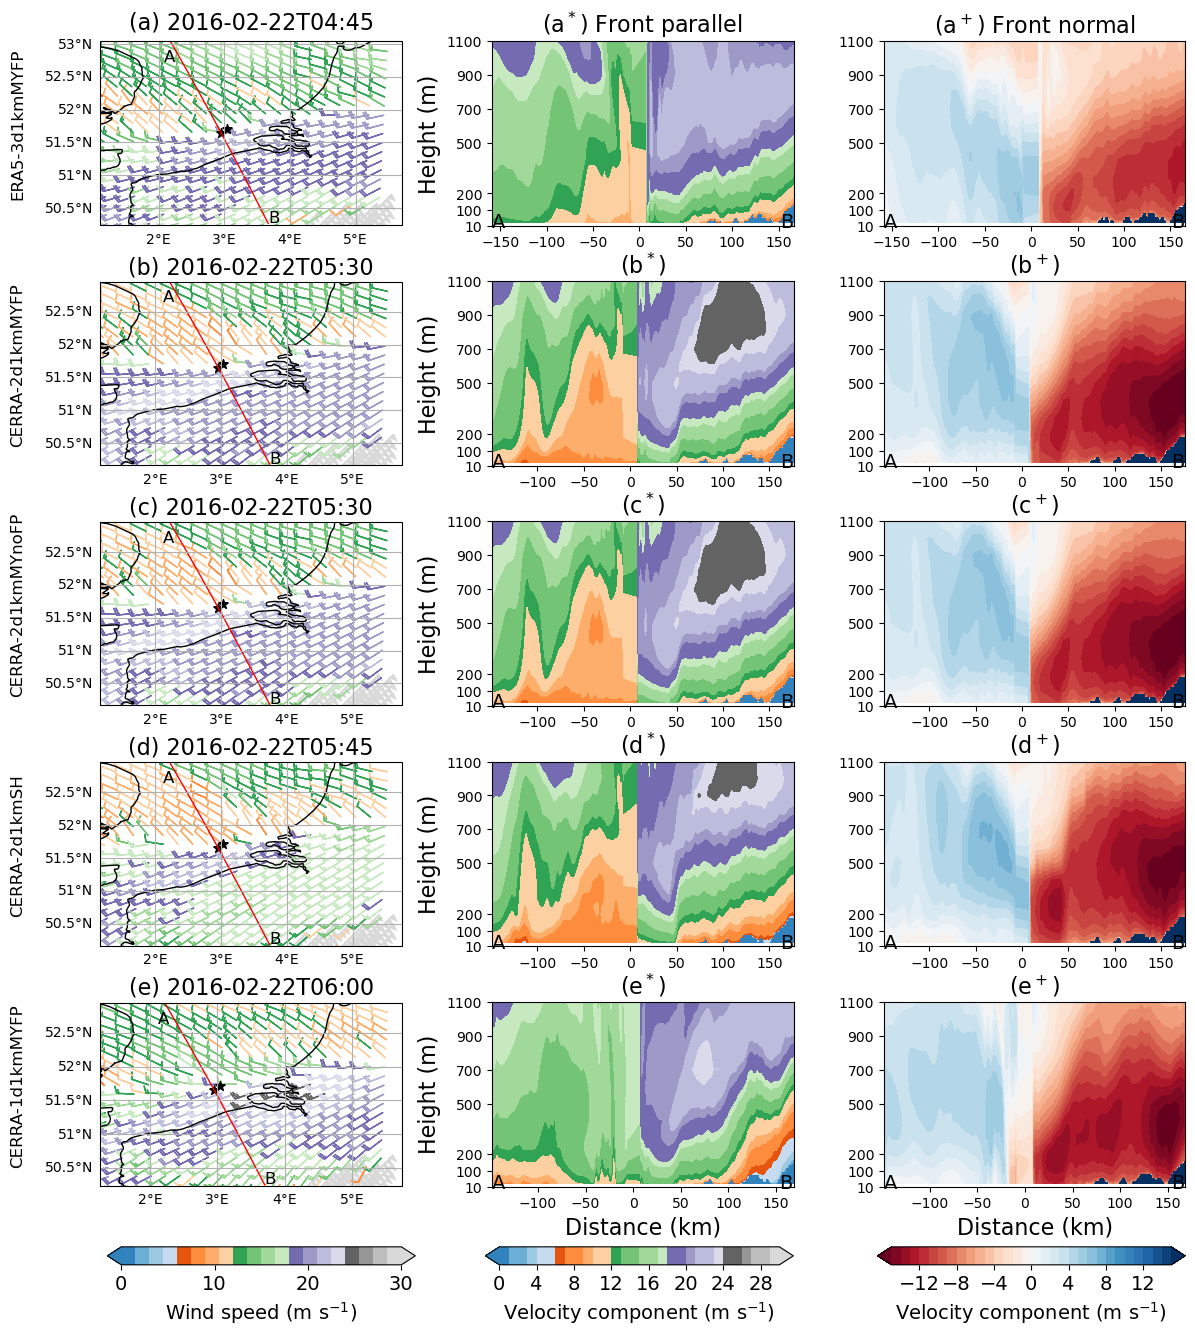

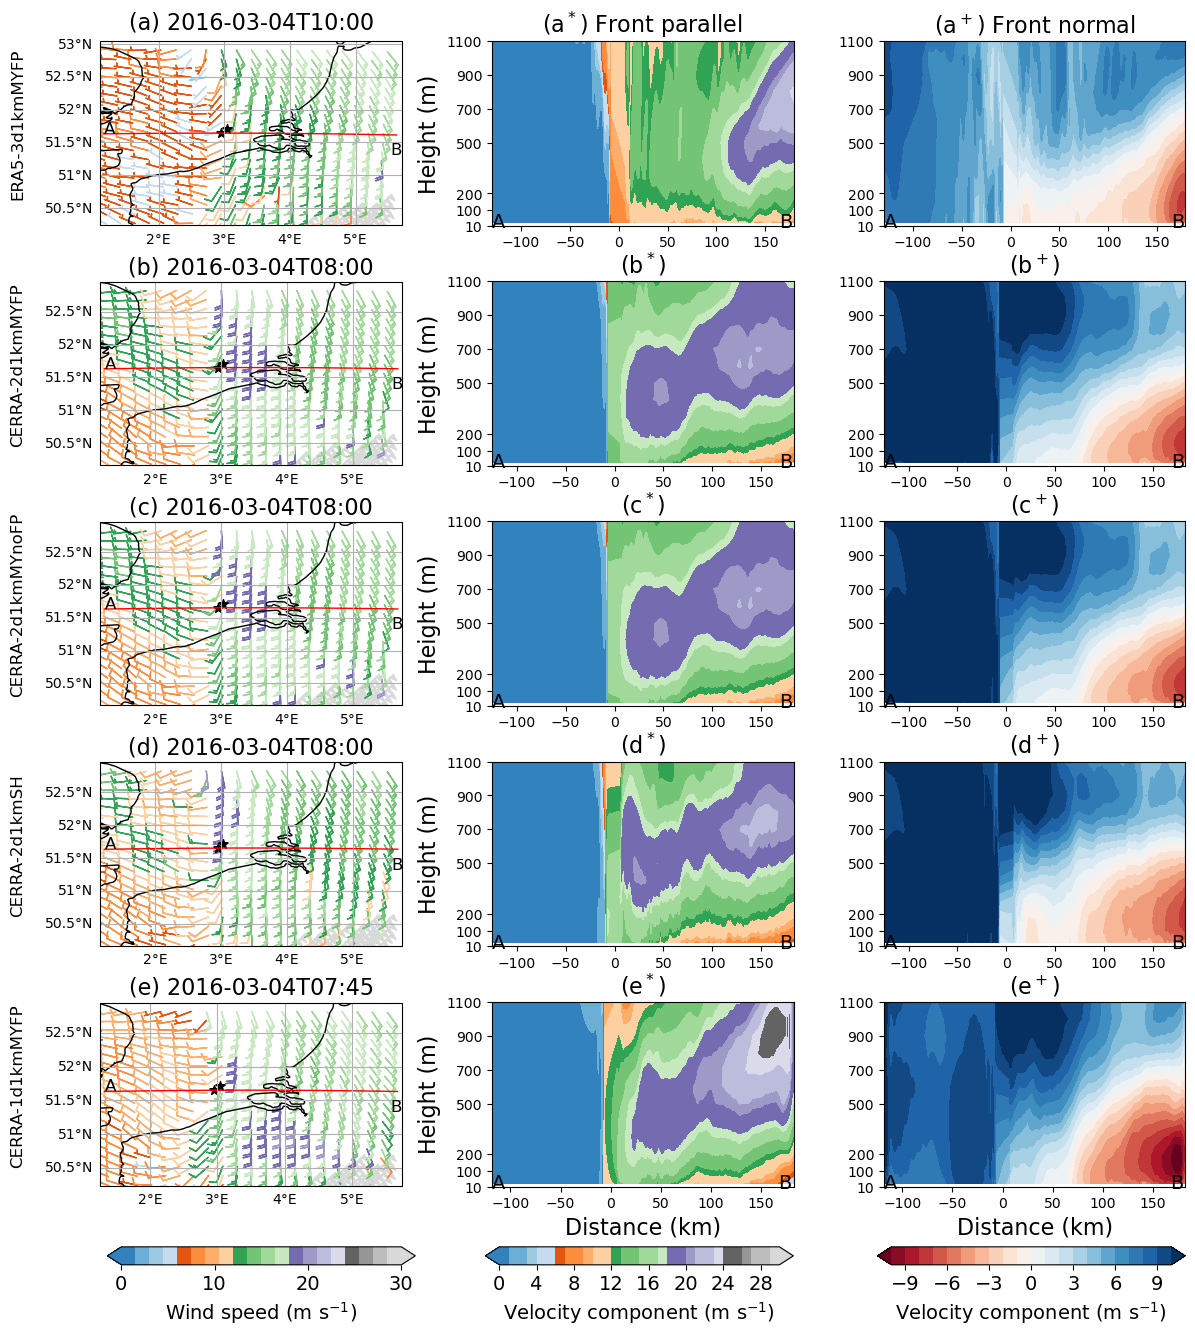

In [ ]:
angles = [165,270]
time_instances = [['2016-02-22T04:45','2016-02-22T05:30','2016-02-22T05:30','2016-02-22T05:45','2016-02-22T06:00'],
                  ['2016-03-04T10:00','2016-03-04T08:00','2016-03-04T08:00','2016-03-04T08:00','2016-03-04T07:45']]
for case in [1,2]:
    case_dir = f'FLLJ_{case}' 
    fig = plt.figure(figsize=(14, 18))
    gs = plt.GridSpec(6,3,width_ratios=[1,1,1],height_ratios=[1,1,1,1,1,1],hspace=0.3,wspace=0.3)
    angle = angles[case-1]

    for i,run in enumerate([1,2,3,4,5]):
        run_dir = run_names[run-1]
        u_data, v_data, XLAT, XLONG, XLAT_line, XLONG_line, XLAT_nline, XLONG_nline, line_distances, normal_component, parallel_component = get_normal_paralel_XLONG_XLAT_u_v(root_dir,case_dir,run,run_dir,time_instances[case-1][i],[1100.0], angle)
        # == First figure - wind barbs ==##
        n = 30  if run == 6 or run == 7 else 15
        title = f'({subplot_letters[i]})'+' '+time_instances[case-1][i]
        ylabel = run_names[run-1]
        ax0 = plot_wind_barbs(fig, gs[i,0], u_data.sel(num_z_levels_stag=200.), v_data.sel(num_z_levels_stag=200.), XLONG, XLAT,n,title,contour_levels[case-1][0],
        normal_and_parallel=case,XLONG_line=XLONG_line,XLAT_line=XLAT_line,XLONG_nline=XLONG_nline,XLAT_nline=XLAT_nline,ylabel=ylabel)

        # == Second figure - normal component ==##
        data = normal_component
        title = rf'({subplot_letters[i]}$^*$)'+' '+'Front parallel' if run == 1 else fr'({subplot_letters[i]}$^*$)'
        ylabel = 'Height (m)'
        xlabel = 'Distance (km)' if run == 5 else None
        ax1 = plot_cross_section(fig, gs[i,1], data, line_distances, title, xlabel, ylabel, contour_levels=contour_levels[case-1][1],cmap='tab20c',case=case)

        # == Third figure - parallel component ==##
        data = parallel_component
        title = f'({subplot_letters[i]}$^+$)'+' '+'Front normal' if run == 1 else f'({subplot_letters[i]}$^+$)'
        ylabel = None
        xlabel = 'Distance (km)' if run == 5 else None
        ax2 = plot_cross_section(fig, gs[i,2], data, line_distances, title, xlabel, ylabel, contour_levels=contour_levels[case-1][2],cmap='RdBu',case=case)

    # Adding colorbar for column 1 figures
    cbarb_ax = fig.add_axes([0.13, 0.2, 0.22, 0.01])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(ax0, cax=cbarb_ax, orientation='horizontal',extend='both',label=r'Wind speed ($\mathrm{m}\ \mathrm{s}^{-1}$)')
    cbar_barb.ax.xaxis.label.set_fontsize(14)
    # Set fontsize for color bar ticks
    cbar_barb.ax.tick_params(axis='x', labelsize=14)

    cbarb_ax = fig.add_axes([0.4, 0.2, 0.22, 0.01])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(ax1, cax=cbarb_ax, orientation='horizontal',extend='both',label=r'Velocity component ($\mathrm{m}\ \mathrm{s}^{-1}$)')
    cbar_barb.ax.xaxis.label.set_fontsize(14)
    # Set fontsize for color bar ticks
    cbar_barb.ax.tick_params(axis='x', labelsize=14)

    cbarb_ax = fig.add_axes([0.68, 0.2, 0.22, 0.01])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(ax2, cax=cbarb_ax, orientation='horizontal',extend='both',label=r'Velocity component ($\mathrm{m}\ \mathrm{s}^{-1}$)')
    cbar_barb.ax.xaxis.label.set_fontsize(14)
    # Set fontsize for color bar ticks
    cbar_barb.ax.tick_params(axis='x', labelsize=14)

    # save figure
    plt.savefig(f'{fig_dir}/FLLJ_{case}_cross_section(3hCERRA).pdf', dpi=300, bbox_inches='tight')

## Wind speed and direction time-series comparison

In [4]:
obs_levels = [30,40,60,100,120,160,200] #the first level, 4 m is excluded
def obs_ws_wdir(start_time,end_time,levels,location):
    df = pd.read_csv(f'{root_dir}/WES_dataset//Lidar_observations/{location}_WindResourceSpeedDirectionTIStat.csv',index_col=0)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.loc[start_time:end_time]
    ws = {}
    wdir = {}
    for level in levels:
        if (level==4):
            ws[float(level)] = df.loc[start_time:end_time,f'WindSpeed{level:03d}m m/s']
            wdir[float(level)] = df.loc[start_time:end_time,f'WindDir{level:03d}m deg']
        else:
            ws[float(level)] = df.loc[start_time:end_time,f'WindSpeed{level:03d}mh m/s']
            wdir[float(level)] = df.loc[start_time:end_time,f'WindDir{level:03d}m deg']
    ws = pd.DataFrame(ws)
    wdir = pd.DataFrame(wdir)
    return ws,wdir

In [5]:
ws_dict = {}
wdir_dict = {}
for case in [1,2]:
    ws_dict[case] = {}
    case_dir = f'FLLJ_{case}'
    ws_dfs = {}
    wdir_dict[case] = {}
    wdir_dfs = {}
    for location in ['LOT2']:
        ws_dfs[location] = []
        wdir_dfs[location] = []
        # observations
        obs_ws,obs_wdir = obs_ws_wdir(ramp_periods[case-1][0],ramp_periods[case-1][1],obs_levels,location)
        ws_dfs[location].append(obs_ws)
        wdir_dfs[location].append(obs_wdir)
        # simulations
        for run in [1,2,3,4,5,16,17]:
            run_dir = run_names[run-1]
            u,v,_,_= extract_u_v(root_dir, case_dir,run,run_dir,dates_range=ramp_periods[case-1],levels=[30,1100],location=buoy_locations[location])
            ws = wind_speed(u,v).to_dataframe().reset_index(level='num_z_levels_stag').pivot(columns='num_z_levels_stag', values='ws')
            ws_dfs[location].append(ws)
            wdir = wind_direction(u,v).to_dataframe().reset_index(level='num_z_levels_stag').pivot(columns='num_z_levels_stag', values='wdir')
            wdir_dfs[location].append(wdir)
    ws_dict[case] = ws_dfs
    wdir_dict[case] = wdir_dfs

Closest indices in the order of latitude (y) and longitude (x) are : (148, 120)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (155, 112)
Closest indices in the order of latitude (y) and longitude (x) are : (155, 112)
Closest indices in the order of latitude (y) and longitude (x) are : (155, 112)
Closest indices in the order of latitude (y) and longitude (x) are : (148, 120)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (158, 116)
Closest indices in the order of latitude (y) and longitude (x) are : (155, 112)
Closest indices in the order of latitude

### wind speed time-series

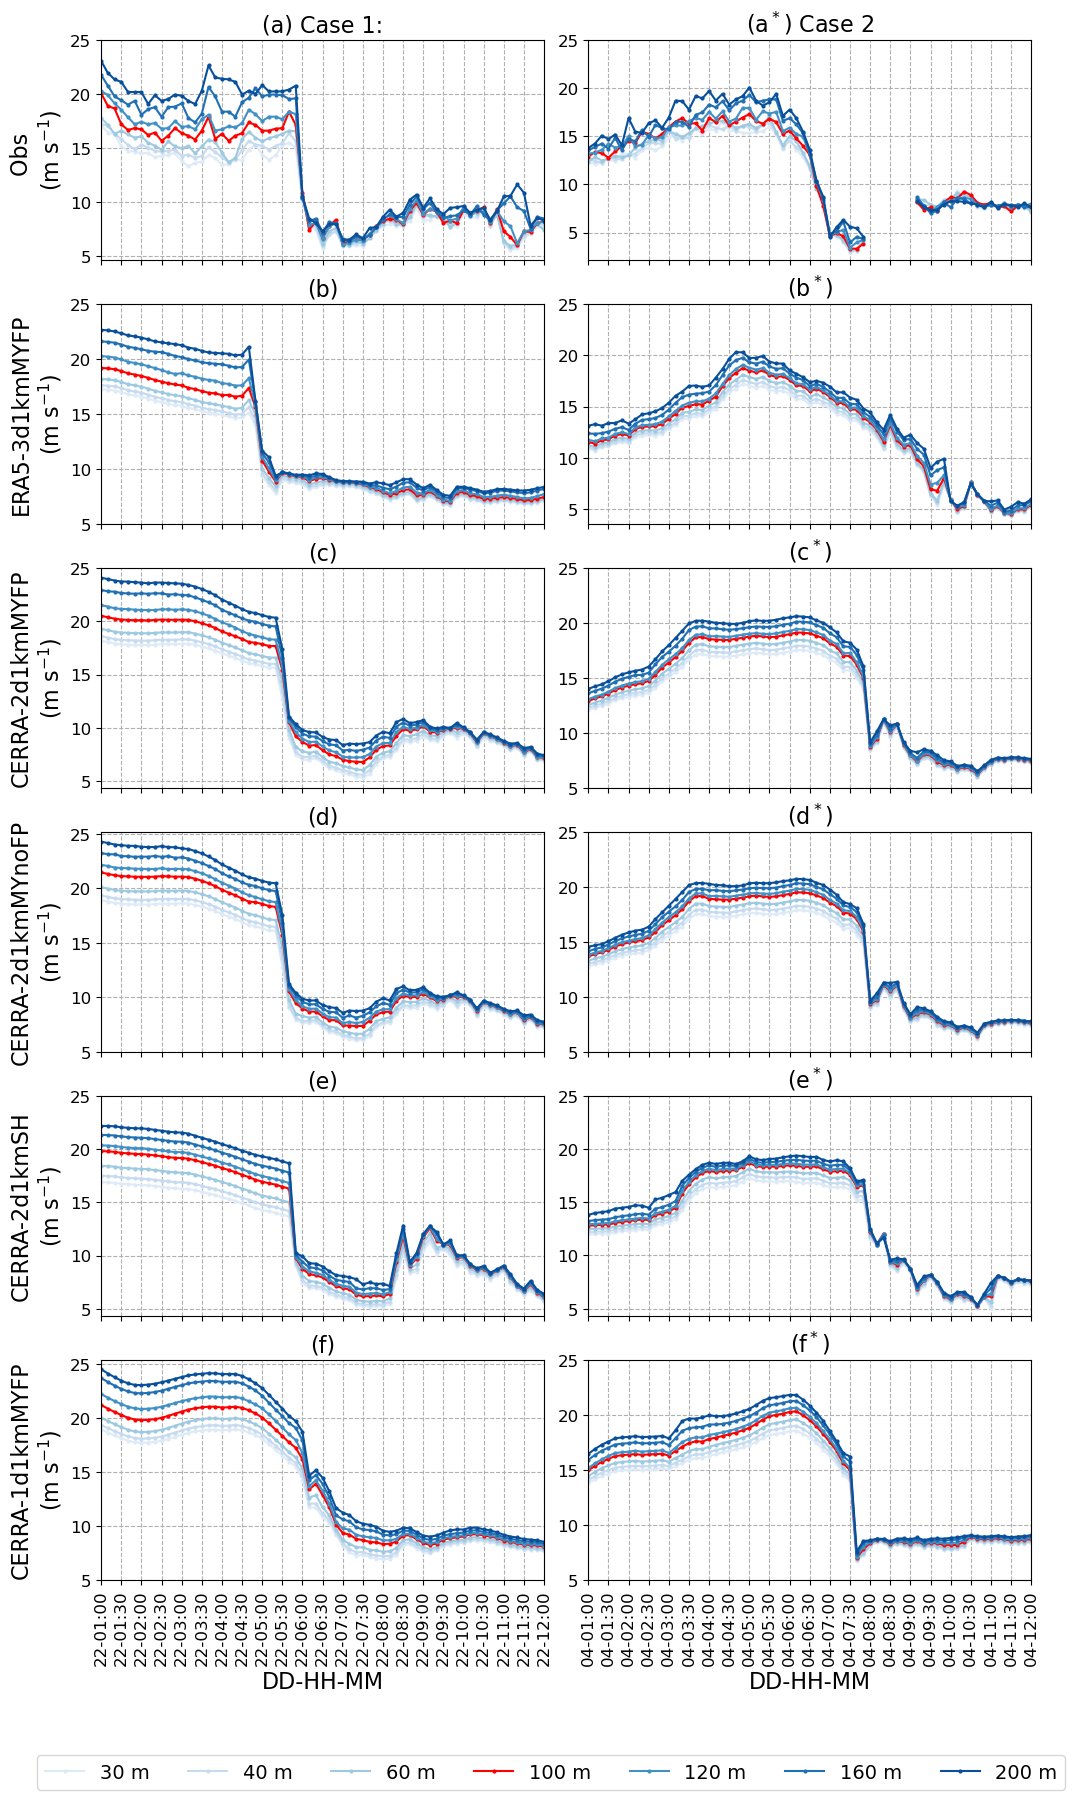

In [9]:
for location in ['LOT2']:
    fig = plt.figure(figsize=(12, 20))
    gs = plt.GridSpec(6,2,hspace=0.2, wspace=0.1)
    for k,case in enumerate([1,2]):

        case_dir = f'FLLJ_{case}'
        ws_dfs = ws_dict[case]
        # create a set of 10 colors in blue, from light to dark
        colors = sns.color_palette("Blues", len(obs_levels))

        # observations
        obs_ws = ws_dfs[location][0]
        j = 0
        ylabel = f'Obs \n'+r'($\mathrm{m}\ \mathrm{s}^{-1}$)' if k == 0 else False
        ax = fig.add_subplot(gs[j,k])
        title = f'({subplot_letters[j]})'+' '+f'Case {case}:' if k == 0 else fr'({subplot_letters[j]}$^*$)'+' '+f'Case {case}'
        for i,level in enumerate(obs_levels):
            color = 'red' if level == 100. else colors[i]
            plot_lines_timeseries(ax,obs_ws.index,obs_ws[level],color,'.','-',f'{level} m',title,
                                xlabel=None,ylabel=ylabel,xticks=False,yticks=np.arange(5, 25.1, 5))
        j = 1
        for run in [1,2,3,4,5]:
            run_dir = f'WRF_run_{run}'
            ws = ws_dfs[location][j]
            run_name = run_names[run-1]
            ax = fig.add_subplot(gs[j,k])
            xlabel = 'DD-HH-MM' if j == 5 else None
            ylabel = f'{run_name}\n'+r'($\mathrm{m}\ \mathrm{s}^{-1}$)' if k == 0 else None
            xticks = True if j == 5 else False
            title = f'({subplot_letters[j]})' if k == 0 else fr'({subplot_letters[j]}$^*$)'
            for i,level in enumerate(obs_levels):
                color = 'red' if level == 100. else colors[i]
                plot_lines_timeseries(ax,ws.index[::2],ws[level][::2],color,'.','-',f'{level} m',title,
                                    xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks=np.arange(5, 25.1, 5))
            j = j+1

        handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles,labels,loc='lower center',ncol=len(labels),bbox_to_anchor=(0.5,0.0),fontsize=14)
    plt.savefig(f'{fig_dir}/FLLJ_1-2_wind_speed_timeseries_{location}(3hCERRA).pdf', dpi=300, bbox_inches='tight')

### wind direction time-series

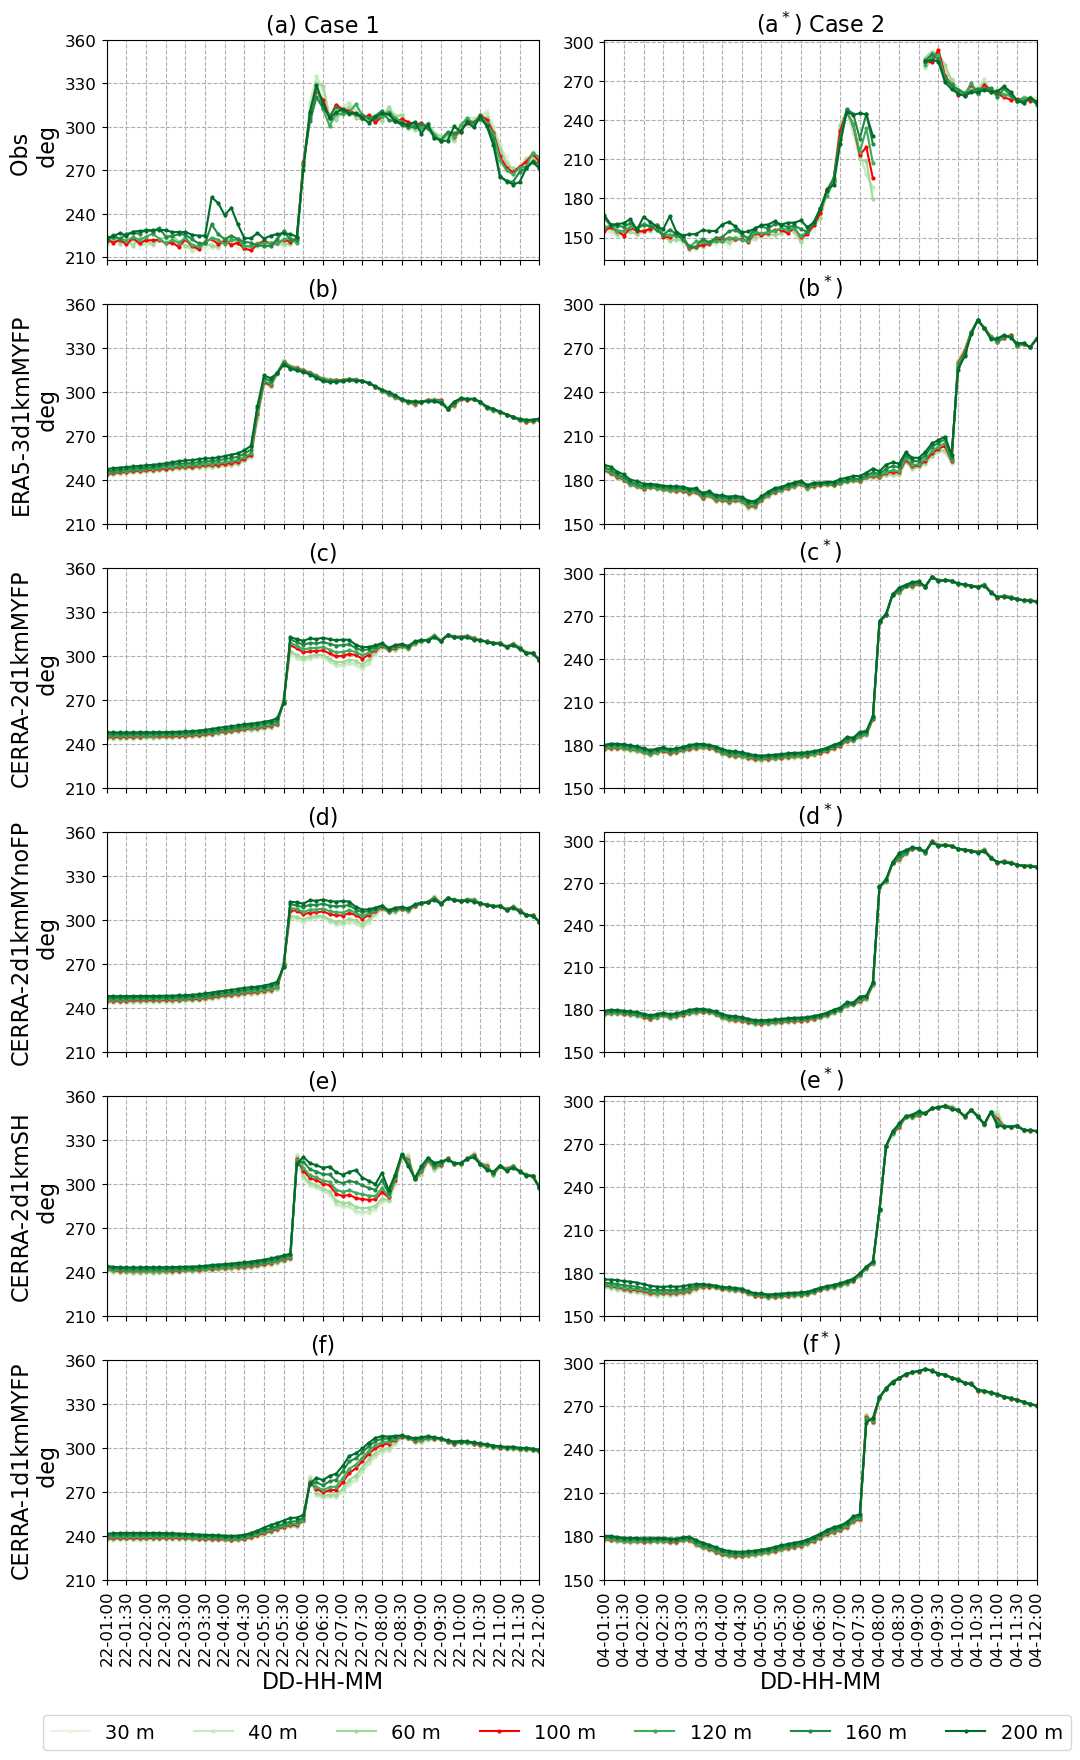

In [10]:
wdir_ticks = [np.arange(210, 360.1, 30),np.arange(150, 300.1, 30)]
for location in ['LOT2']:
    fig = plt.figure(figsize=(12, 20))
    gs = plt.GridSpec(6,2,hspace=0.2, wspace=0.15)
    for k,case in enumerate([1,2]):

        case_dir = f'FLLJ_{case}'
        wdir_dfs = wdir_dict[case]
        # create a set of 10 colors in blue, from light to dark
        colors = sns.color_palette("Greens", len(obs_levels))

        # observations
        obs_wdir = wdir_dfs[location][0]
        j = 0
        title = f'({subplot_letters[j]})'+' '+f'Case {case}' if k == 0 else fr'({subplot_letters[j]}$^*$)'+' '+f'Case {case}'
        ylabel = f'Obs \n deg' if k == 0 else False
        ax = fig.add_subplot(gs[j,k])
        for i,level in enumerate(obs_levels):
            color = 'red' if level == 100. else colors[i]
            plot_lines_timeseries(ax,obs_wdir.index,obs_wdir[level],color,'.','-',f'{level} m',title,
                                xlabel=None,ylabel=ylabel,xticks=False,yticks=wdir_ticks[k])
        j = 1
        for run in [1,2,3,4,5]:
            run_dir = f'WRF_run_{run}'
            wdir = wdir_dfs[location][j]
            ax = fig.add_subplot(gs[j,k])
            xlabel = 'DD-HH-MM' if j == 5 else None
            ylabel = f'{run_names[run-1]}\n deg' if k == 0 else None
            xticks = True if j == 5 else False
            title = f'({subplot_letters[j]})' if k == 0 else fr'({subplot_letters[j]}$^*$)'
            for i,level in enumerate(obs_levels):
                color = 'red' if level == 100. else colors[i]
                plot_lines_timeseries(ax,wdir.index[::2],wdir[level][::2],color,'.','-',f'{level} m',title,
                                    xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks=wdir_ticks[k])
            j = j+1

        handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles,labels,loc='lower center',ncol=len(labels),bbox_to_anchor=(0.5,0.02),fontsize=14)
    plt.savefig(f'{fig_dir}/FLLJ_1-2_wind_direction_timeseries_{location}(3hCERRA).pdf', dpi=300, bbox_inches='tight')

### Wind speed time-height cross-section

In [11]:
def plot_time_height_crosssection(ax,index,columns,data,levels,cmap,title,xlabel=None,ylabel=None,xticks=None,yticks=None,tick_interval=3,jet_heights=None,norm=None):
    contour = ax.contourf(index,columns,data,levels=levels,cmap=cmap,extend='both',norm=norm)
    ax.set_title(title,fontsize=16)
    ax.set_ylabel(ylabel,fontsize=16) if ylabel else None
    ax.set_xlabel(xlabel,fontsize=16) if xlabel else None
    # set y-axis tick labels font size
    ax.tick_params(axis='y', labelsize=12)

    # get x-axis ticks at every 30 minutes
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%da-%H-%M'))
    minute_locator = MinuteLocator(interval=30)
    ax.xaxis.set_minor_locator(minute_locator)
    ax.set_xticks(index[::tick_interval])
    
    if xticks:
        # Set x-axis tick labels in day-hr-min format
        ax.set_xticklabels([dt.strftime('%d-%H:%M') for dt in index[::tick_interval]], rotation='vertical', fontsize=12)
    else:
        # dont set x ticks labels
        ax.set_xticklabels([])
    
    ax.set_xlim(index[0],index[-1])

    # set y-axis ticks
    if yticks is not None:
        ax.set_yticks(yticks)
    else:
        ax.set_yticks([])

    if jet_heights is not None:
        ax.plot(jet_heights.index, jet_heights, color='black', linestyle='-', linewidth=2)

    return contour 

In [12]:
def LLJ_detection(ws):
    # Determine the index (time) and columns (height levels)
    times = ws.index
    heights = ws.columns

    # Initialize lists to store the results
    core_speeds = []
    core_heights = []
    jet = []

    # Iterate over each time step
    for time in times:
        wind_speed = ws.loc[time, :]

        # Core speed and core height: Local wind maximum within the lowest 1 km
        core_index = wind_speed.argmax()
        core_speed = wind_speed.iloc[core_index]
        core_height = heights[core_index]

        # Fall off criteria
        below_core = wind_speed[wind_speed.index <= core_height]
        above_core = wind_speed[wind_speed.index >= core_height]

        increase_below = (below_core <= core_speed - 1).any() and (below_core <= 0.9 * core_speed).any()
        decrease_above = (above_core <= core_speed - 1).any() and (above_core <= 0.9 * core_speed).any()

        condition3 = increase_below & decrease_above

        # Combine all conditions
        if condition3:
            jet.append(condition3)
            core_speeds.append(core_speed)
            core_heights.append(core_height)
        else:
            jet.append(False)
            core_speeds.append(np.nan)
            core_heights.append(np.nan)

    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'core_speed': core_speeds,
        'core_height': core_heights,
        'jet': jet
    }, index=times)

    return results

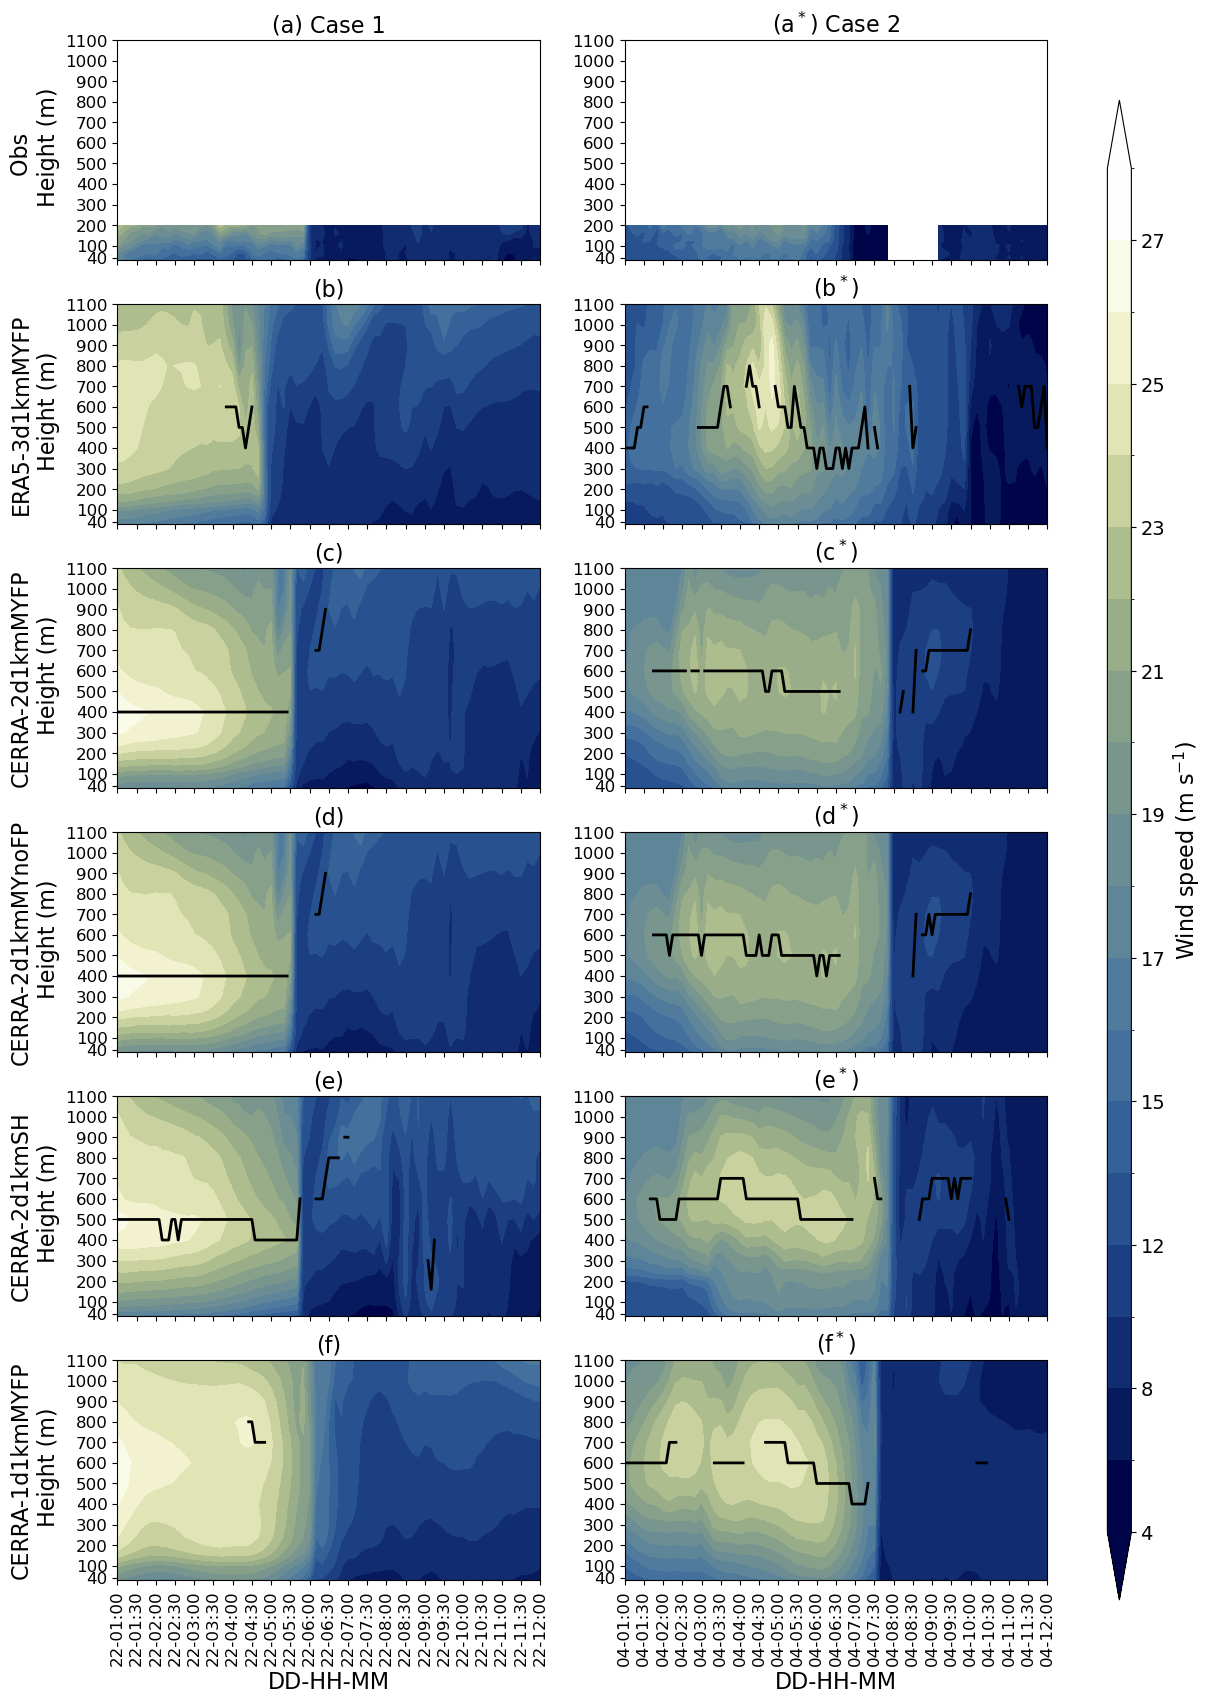

In [13]:
yticks = [40,100,200,300,400,500,600,700,800,900,1000,1100]

levels = np.arange(4, 14, 2)
levels = np.append(levels, np.arange(14, 28.1, 1))
len(levels)
from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a custom colormap with 20 distinct colors
cmap = plt.get_cmap(cm.davos, len(levels) - 1)  # Number of color segments should match `len(levels) - 1`
norm = BoundaryNorm(levels, cmap.N)

for location in ['LOT2']:
    fig = plt.figure(figsize=(12, 20))
    gs = plt.GridSpec(6,2,hspace=0.2, wspace=0.2)
    for k,case in enumerate([1,2]):

        case_dir = f'FLLJ_{case}'
        ws_dfs = ws_dict[case]

        # observations
        obs_ws = ws_dfs[location][0]
        j = 0
        ylabel = f'Obs \n Height (m)' if k == 0 else False
        ax = fig.add_subplot(gs[j,k])
        title = f'({subplot_letters[j]})'+' '+f'Case {case}' if k == 0 else fr'({subplot_letters[j]}$^*$)'+' '+f'Case {case}'
        mapable = plot_time_height_crosssection(ax,obs_ws.index,obs_ws.columns,obs_ws.T,levels,cmap,title,xlabel=None,ylabel=ylabel,xticks=False,yticks= yticks,norm=norm)

        j = 1
        for run in [1,2,3,4,5]:
            run_dir = f'WRF_run_{run}'
            ws = ws_dfs[location][j]
            result = LLJ_detection(ws)
            run_name = run_names[run-1]
            ax = fig.add_subplot(gs[j,k])
            xlabel = 'DD-HH-MM' if j == 5 else None
            ylabel = f'{run_name}\n Height (m)' if k == 0 else None
            xticks = True if j == 5 else False
            title = f'({subplot_letters[j]})' if k == 0 else fr'({subplot_letters[j]}$^*$)'
            mapable = plot_time_height_crosssection(ax,ws.index[::2],ws.columns,ws[::2].T,levels,cmap,title,xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks= yticks,jet_heights=result['core_height'],norm=norm)

            j = j+1
    # Adding colorbar
    cbarb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(mapable, cax=cbarb_ax, orientation='vertical',extend='both')
    cbar_barb.ax.set_ylabel('Wind speed '+r'($\mathrm{m}\ \mathrm{s}^{-1}$)', fontsize=16)
    cbar_barb.ax.tick_params(labelsize=14)
    plt.savefig(f'{fig_dir}/FLLJ_1-2_wind_speed_timeheight_{location}(3hCERRA).pdf', dpi=300, bbox_inches='tight')

### Spin-up time sensitivity

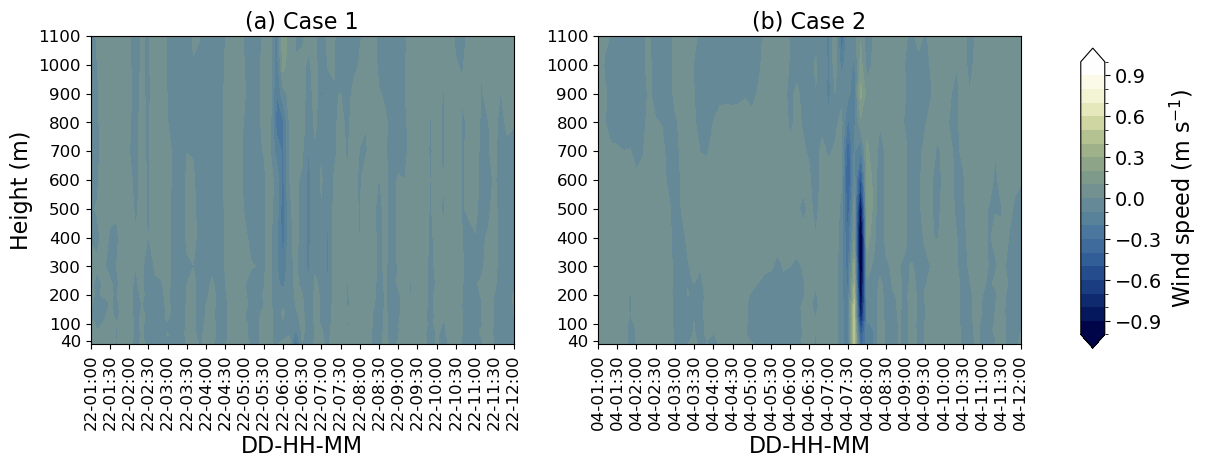

In [45]:
yticks = [40,100,200,300,400,500,600,700,800,900,1000,1100]

levels = np.arange(4, 14, 2)
levels = np.append(levels, np.arange(14, 28.1, 1))
levels = np.arange(-1,1.1,0.1)
len(levels)
from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a custom colormap with 20 distinct colors
cmap = plt.get_cmap(cm.davos, len(levels) - 1)  # Number of color segments should match `len(levels) - 1`
norm = BoundaryNorm(levels, cmap.N)

for location in ['LOT2']:
    fig = plt.figure(figsize=(12, 4))
    gs = plt.GridSpec(1,2,hspace=0.2, wspace=0.2)
    for k,case in enumerate([1,2]):
        case_dir = f'FLLJ_{case}'
        ws_dfs = ws_dict[case]
        run = 5
        run_dir = f'WRF_run_{run}'
        ws5 = ws_dfs[location][5]
        run = 17
        run_dir = f'WRF_run_{run}'
        ws17 = ws_dfs[location][7]

        ws_diff = ws17-ws5
        ax = fig.add_subplot(gs[0,k])
        xlabel = 'DD-HH-MM'
        ylabel = f'Height (m)' if k == 0 else None
        xticks = True 
        title = f'({subplot_letters[k]})'+' '+f'Case {case}'
        mapable = plot_time_height_crosssection(ax,ws_diff.index[::2],ws_diff.columns,ws_diff[::2].T,levels,cmap,title,xlabel=xlabel,ylabel=ylabel,xticks=xticks,yticks= yticks,jet_heights=None,norm=norm)

    # Adding colorbar
    cbarb_ax = fig.add_axes([0.95, 0.1, 0.02, 0.75])  # [left, bottom, width, height]
    cbar_barb = plt.colorbar(mapable, cax=cbarb_ax, orientation='vertical',extend='both')
    cbar_barb.ax.set_ylabel('Wind speed '+r'($\mathrm{m}\ \mathrm{s}^{-1}$)', fontsize=16)
    cbar_barb.ax.tick_params(labelsize=14)
    plt.savefig(f'{fig_dir}/FLLJ_1-2_wind_speed_timeheight_difference_{location}(3hCERRA)_spinup_sensitivity.pdf', dpi=300, bbox_inches='tight')

### Wind profiles

In [46]:
from matplotlib.ticker import MultipleLocator
def plot_wind_profile(ax, data, levels, color,line_style, marker, label, xlabel, ylabel, title, xticks, yticks):
    ax.plot(data, levels, line_style, color=color, marker=marker, label=label, markersize=4, linewidth=2)
    if xticks is not None:
        ax.set_xticks(xticks)
        ax.xaxis.set_minor_locator(MultipleLocator(1))  # Set minor ticks at every 1 value
        ax.tick_params(axis='x', which='minor', bottom=True, labelbottom=False)  # Hide minor tick labels
    if yticks is not None:
        ax.set_yticks(yticks)
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=16)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=16)
    if title is not None:
        ax.set_title(title, fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)

    return ax

22T01:00 2016-02-22T02:00
22T02:00 2016-02-22T03:00
22T03:00 2016-02-22T04:00
04T03:00 2016-03-04T04:00
04T04:00 2016-03-04T05:00
04T05:00 2016-03-04T06:00


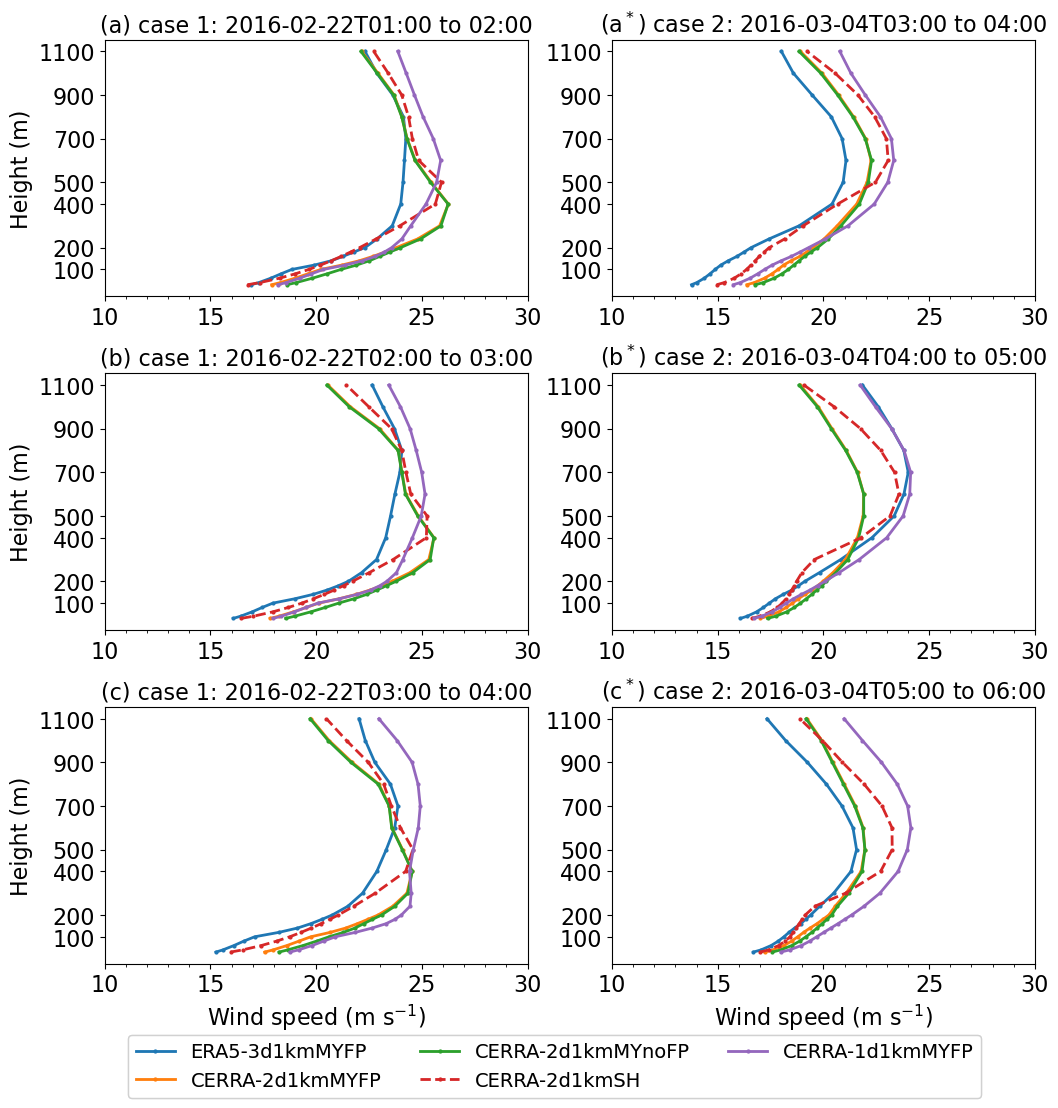

In [47]:
# create 10 colors and 10 markers
colors = sns.color_palette("tab10", 10)
markers = ['o','s','^','v','<','>','1','2','3','4','5']
linestyles = ['-','-','-','--','-','--','--']
time_instances = ['2016-02-22T04:00','2016-03-04T06:00']

for location in ['LOT2']:
    fig = plt.figure(figsize=(12, 12))
    gs = plt.GridSpec(3,2,hspace=0.3, wspace=0.2)
    for i,case in enumerate([1,2]):
        case_dir = f'FLLJ_{case}'
        ws_dfs = ws_dict[case]
        for j,hour in enumerate(range(3,0,-1)):
            instance_start = ((datetime.strptime(time_instances[case-1], '%Y-%m-%dT%H:%M'))-timedelta(hours=hour)).strftime('%Y-%m-%dT%H:%M')
            instance_end = ((datetime.strptime(instance_start, '%Y-%m-%dT%H:%M'))+timedelta(hours=1)).strftime('%Y-%m-%dT%H:%M')
            print(instance_start[-8:],instance_end)

            xlabel = r'Wind speed ($\mathrm{m}\ \mathrm{s}^{-1}$)' if j == 2 else None
            ylabel = 'Height (m)' if i == 0 else None
            title = f'({subplot_letters[j]}) case {case}: {instance_start} to {instance_end[-5:]}' if i == 0 else fr'({subplot_letters[j]}$^*$) case {case}: {instance_start} to {instance_end[-5:]}'
            xticks = np.arange(10,30.1,5)
            yticks = [100, 200, 400, 500, 700, 900, 1100]
            ax = fig.add_subplot(gs[j,i])

            #OBS = ws_dfs[location][0][instance_start:instance_end]
            #plot_wind_profile(ax,np.squeeze(OBS.mean().values), OBS.columns,'black','-', 'o', f'{location} observed', xlabel, ylabel, title, xticks, yticks)
            for run in [1,2,3,4,5]:
                run_dir = f'WRF_run_{run}'
                SIM = ws_dfs[location][run][instance_start:instance_end]
                plot_wind_profile(ax,np.squeeze(SIM.mean().values),SIM.columns,colors[run-1],linestyles[run-1],'.',run_names[run-1],xlabel, ylabel, title, xticks, yticks)

        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles,labels,loc='lower center',ncol=3,bbox_to_anchor=(0.5,-0.01),fontsize=14)
    #plt.savefig(f'{fig_dir}/FLLJ_{location}_jet_wind_speed_profiles(3hCERRA).pdf', dpi=300, bbox_inches='tight')

# Wind wakes from MYNN and No-MYNN

In [35]:
def map_plotter(fig,gs,data,x,y,levels,cmap,title,cbar_args,extent=None,rectangles=None,sample_points=None,turbine_locs=False,bottom_labels=False,left_labels=False,norm=None):    
    ax = fig.add_subplot(gs,projection=ccrs.PlateCarree())
    ax.coastlines()

    contour = data.plot.contourf(
        x=x,y=y,levels=levels,add_colorbar=False,cmap = cmap,extend='both',
        #cbar_kwargs = {'orientation':orientation, 'shrink':shrink, 'aspect':40, 'label':cbar_label,'fontsize':14},
        ax=ax, norm = norm)
    
    # Add colorbar with font size
    if cbar_args is not None:
        cbar = fig.colorbar(contour, orientation=cbar_args['orientation'], shrink=cbar_args['shrink'], aspect=40, label=cbar_args['cbar_label'])
        cbar.ax.tick_params(labelsize=12)
        cbar.ax.set_xlabel(cbar_args['cbar_label'], fontsize=12)
    
    if extent:
        # Set the extent (for example, bounding box for Europe)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = False 
    gl.bottom_labels = False
    if bottom_labels:
        gl.bottom_labels = True
    if left_labels:
        gl.left_labels = True
    
    # Set x and y ticks font size
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    
    # set title
    ax.set_title(title,fontsize=14)
    
    # Add land feature with grey color
    land_feature = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m', edgecolor='face', facecolor='lightgrey'
    )
    ax.add_feature(land_feature)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1, edgecolor='black')
    
    if sample_points:
        for label, (lat, lon) in sample_points.items():
            ax.text(lon, lat - 0.05, label, color='black', fontsize=14, ha='center', va='center')
            ax.plot(lon, lat, '.', markersize=8,color='black')
    if turbine_locs:
        ds = xr.open_dataset(f'{root_dir}/borssele_wind_turbines.nc')
        for i in range(len(ds.lon)):
            ax.plot(ds.lon[i], ds.lat[i], '.', markersize=0.5,color='black')
    return ax

2016-02-22_04:00:00
2016-02-22_04:30:00
2016-02-22_05:00:00
2016-02-22_05:30:00
2016-02-22_06:00:00
2016-02-22_06:30:00
2016-02-22_07:00:00
2016-02-22_07:30:00
2016-02-22_04:00:00
2016-02-22_04:30:00
2016-02-22_05:00:00
2016-02-22_05:30:00
2016-02-22_06:00:00
2016-02-22_06:30:00
2016-02-22_07:00:00
2016-02-22_07:30:00
2016-03-04_05:00:00
2016-03-04_05:30:00
2016-03-04_06:00:00
2016-03-04_06:30:00
2016-03-04_07:00:00
2016-03-04_07:30:00
2016-03-04_08:00:00
2016-03-04_08:30:00
2016-03-04_05:00:00
2016-03-04_05:30:00
2016-03-04_06:00:00
2016-03-04_06:30:00
2016-03-04_07:00:00
2016-03-04_07:30:00
2016-03-04_08:00:00
2016-03-04_08:30:00


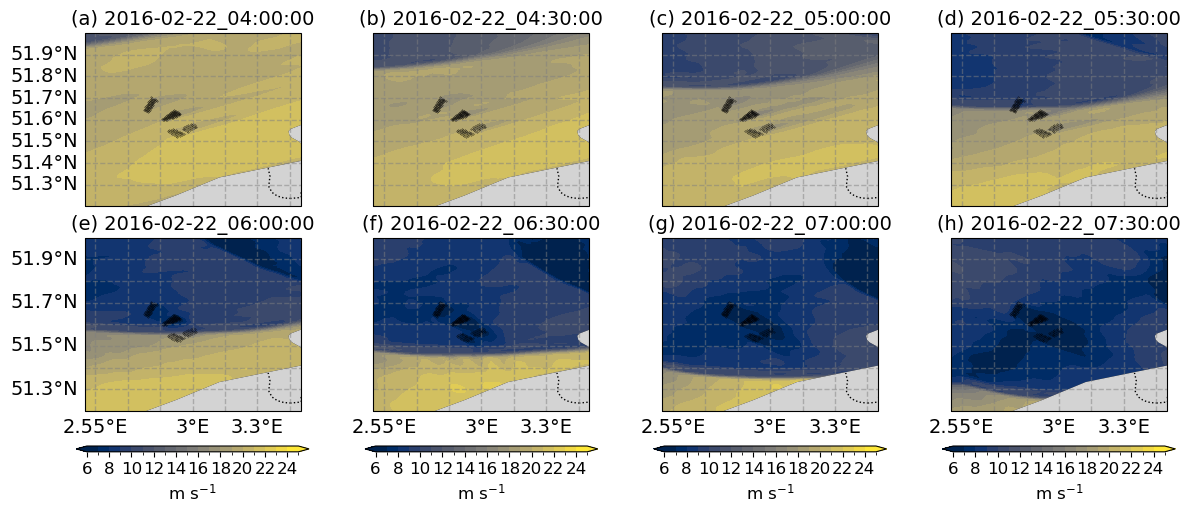

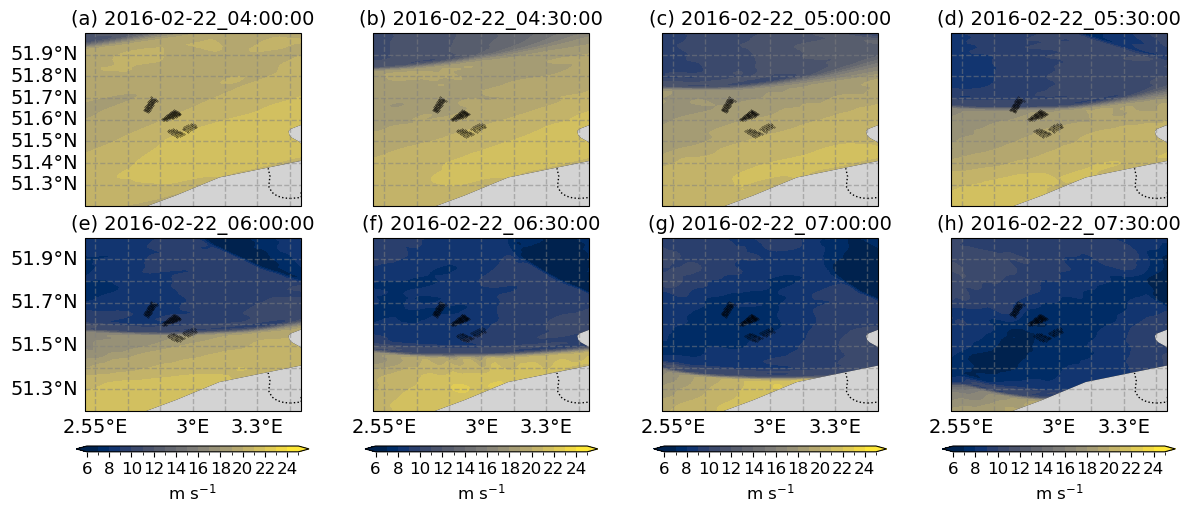

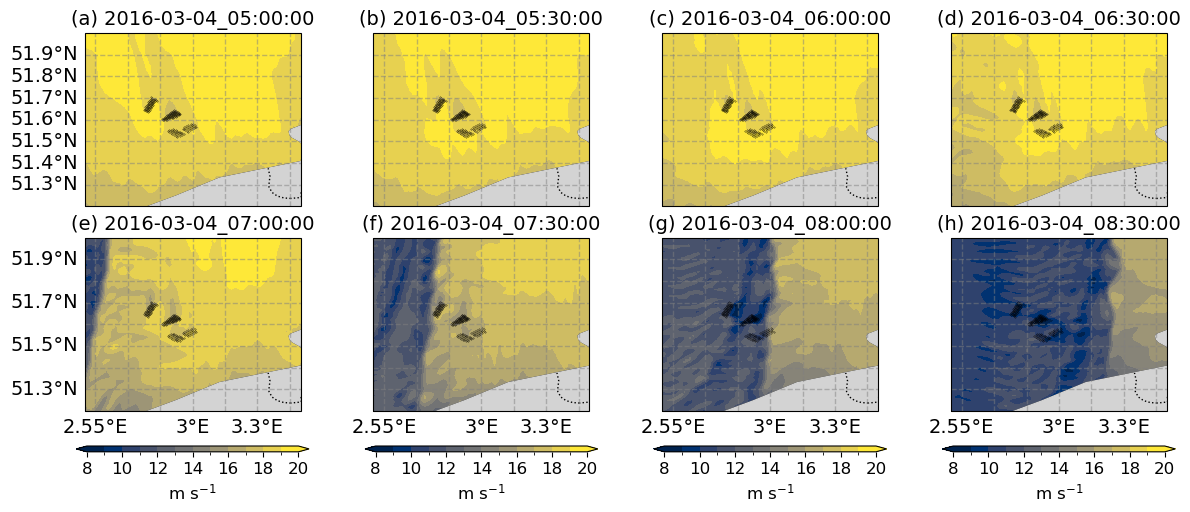

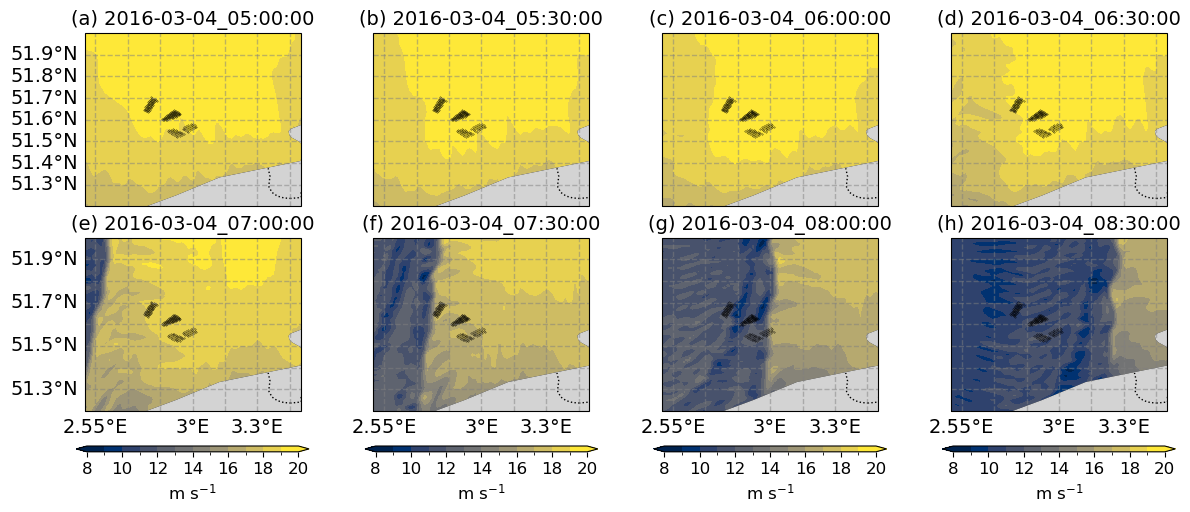

In [43]:
for case in [1,2]:
    if case ==1:
        levels = np.arange(6,25.1,1)
        from matplotlib.colors import ListedColormap, BoundaryNorm
        # Create a custom colormap with 20 distinct colors
        cmap = plt.get_cmap('cividis', len(levels) - 1)  # Number of color segments should match `len(levels) - 1`
        norm = BoundaryNorm(levels, cmap.N)
    else:
        levels = np.arange(8,20.1,1)
        from matplotlib.colors import ListedColormap, BoundaryNorm
        # Create a custom colormap with 20 distinct colors
        cmap = plt.get_cmap('cividis', len(levels) - 1)  # Number of color segments should match `len(levels) - 1`
        norm = BoundaryNorm(levels, cmap.N)

    case_dir = f'FLLJ_{case}'
    for run in [2,3]:
        run_dir = run_names[run-1]
        dates_range = ramp_periods[case-1]
        height_levels = 100.
        u,v,XLONG,XLAT = extract_u_v(root_dir,case_dir,run,run_dir,dates_range,height_levels)
        ws = wind_speed(u,v)
        ws = ws.assign_coords({"XLONG": (("south_north", "west_east"), XLONG),
                       "XLAT": (("south_north", "west_east"), XLAT)})

        extent = [2.5, 3.5, 51.2, 52]
        # create cmap for wind speed with increasing intensity of blues
        fig = plt.figure(figsize=(12, 5), constrained_layout=True)
        gs = fig.add_gridspec(2,4)
        cbar_args = {'shrink':0.8,'cbar_label':f'm/s','orientation':'horizontal'}
        # create 6 time slices from 2016-02-22T05:30 to 2016-02-22T06:30, at every 10 minutes
        # Extract the first date from ramp_period
        first_date = datetime.fromisoformat(ramp_periods[case-1][0])
        # Add 3 hours to the first date to get the start slice
        
        start_slice = first_date + timedelta(hours=3) if case == 1 else first_date + timedelta(hours=4)
        time_slices = [start_slice + timedelta(minutes=30)*i for i in range(8)]

        for i,time_slice in enumerate(time_slices):
            date = time_slice
            date = pd.to_datetime(date).strftime('%Y-%m-%d_%H:%M:%S')
            print(date)

            bottom_labels = False if i//4 != 1  else True
            left_labels = False if i % 4 != 0 else True
            cbar_args = {'shrink':0.83,'cbar_label':'$\mathrm{m\ s^{-1}}$','orientation':'horizontal'} if i//4 == 1 else None
            title = f'({subplot_letters[i]}) {date}'
            axs = map_plotter(fig,gs[i//4,i%4],ws.sel(Time=time_slice,method='nearest'),'XLONG','XLAT',
                            levels,cmap,title,cbar_args,
                            sample_points = None,extent=extent,turbine_locs=True,bottom_labels=bottom_labels,left_labels=left_labels,norm=norm)
        plt.savefig(f'{fig_dir}/{case_dir}_wind_speed_{run}(3hCERRA).png',dpi=300)
